# Using Time Series Analysis For Sales and Demand Forecasting

## Table of Contents

- [1. Project Overview](#1-project-overview)
- [2. Data Collection & Preprocessing](#2-data-collection--preprocessing)
  - [2.1. Data Loading & Initial Cleaning](#21-data-loading--initial-cleaning)
  - [2.2. Resampling & Filtering Sales Data](#22-resampling--filtering-sales-data)
  - [2.3. Handling Missing Values](#23-handling-missing-values)
- [3. Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda)
  - [3.1. Sales Trends & Seasonality](#31-sales-trends--seasonality)
  - [3.2. Stationarity Check (ADF Test)](#32-stationarity-check-adf-test)
  - [3.3. Autocorrelation Analysis (ACF & PACF)](#33-autocorrelation-analysis-acf--pacf)
- [4. Classical Time Series Models](#4-classical-time-series-models)
  - [4.1. SARIMA Model Selection (Auto ARIMA)](#41-sarima-model-selection-auto-arima)
  - [4.2. Residual Analysis & Model Diagnostics](#42-residual-analysis--model-diagnostics)
  - [4.3. Forecasting & Performance Evaluation](#43-forecasting--performance-evaluation)
- [5. Machine Learning Approach](#5-machine-learning-approach)
  - [5.1. Feature Engineering for XGBoost](#51-feature-engineering-for-xgboost)
  - [5.2. Cross-Validation & Hyperparameter Tuning](#52-cross-validation--hyperparameter-tuning)
  - [5.3. XGBoost Forecasting & Evaluation](#53-xgboost-forecasting--evaluation)
- [6. Deep Learning Approach](#6-deep-learning-approach)
  - [6.1. LSTM Model Design & Training](#61-lstm-model-design--training)
  - [6.2. Hyperparameter Optimisation (Keras Tuner)](#62-hyperparameter-optimisation-keras-tuner)
  - [6.3. Forecasting & Performance Metrics](#63-forecasting--performance-metrics)
- [7. Hybrid Models](#7-hybrid-models)
  - [7.1. Sequential Hybrid (SARIMA + LSTM Residuals)](#71-sequential-hybrid-sarima--lstm-residuals)
  - [7.2. Parallel Hybrid (Weighted SARIMA & LSTM)](#72-parallel-hybrid-weighted-sarima--lstm)
  - [7.3. Performance Comparison of Hybrid Approaches](#73-performance-comparison-of-hybrid-approaches)
- [8. Monthly Aggregation & Forecasting](#8-monthly-aggregation--forecasting)
  - [8.1. Training SARIMA & XGBoost Models](#81-training-sarima--xgboost-models)
  - [8.2. Forecasting Monthly Sales](#82-forecasting-monthly-sales)
- [9. Conclusion](#9-conclusion)


## Project Overview

This project aims to forecast book sales for *The Alchemist* and *The Very Hungry Caterpillar* using various time series models. We explore traditional statistical models (ARIMA, SARIMA), machine learning (XGBoost), deep learning (LSTM), and hybrid approaches that combine SARIMA and LSTM. The models are evaluated at both weekly and monthly levels, comparing their accuracy using MAE and MAPE. The objective is to determine which approach provides the most reliable forecasts for different time granularities, helping guide inventory and sales planning.

## Installing and Importing Libraries

In [ ]:
# Installing required libraries
!pip install openpyxl --quiet
!pip install pmdarima --quiet
!pip install keras-tuner --quiet

In [ ]:
# Importing essential libraries for data manipulation, visualisation, and modelling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import pickle
from google.colab import drive
import warnings

# Importing time series-specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Importing machine learning and deep learning libraries
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras_tuner import RandomSearch, Hyperband
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, ParameterGrid
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import MeanSquaredError

# Setting random seeds for reproducibility
import random
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading & Preprocessing

### Data Loading & Initial Cleaning

In [ ]:
# Path to metadata
isbn_list_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/ISBN List.xlsx"

# Tab names for the metadata
tabs_metadata = ['F - Adult Fiction',
                 'S Adult Non-Fiction Specialist',
                 'T Adult Non-Fiction Trade',
                 "Y Childrens, YA & Educational"]

# Path to save processed metadata
processed_metadata_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/processed_metadata.pkl"

try:
    if os.path.exists(processed_metadata_path):
        # Loading from saved file if available
        with open(processed_metadata_path, "rb") as f:
            metadata_combined = pickle.load(f)
        print("Loaded metadata from saved file.")
    else:
        raise FileNotFoundError
except (EOFError, FileNotFoundError, pickle.UnpicklingError):
    print("Processed metadata file not found or invalid. Reloading from source.")

    # Loading all tabs and combine into a single DataFrame
    metadata = {tab: pd.read_excel(isbn_list_path, sheet_name=tab) for tab in tabs_metadata}
    metadata_combined = pd.concat(metadata.values(), ignore_index=True)

    # Saving the combined metadata
    with open(processed_metadata_path, "wb") as f:
        pickle.dump(metadata_combined, f)
    print("Metadata loaded and saved for future use.")

# Verifying combined metadata
print("Combined metadata shape:", metadata_combined.shape)
print(metadata_combined.head())


Loaded metadata from saved file.
Combined metadata shape: (500, 10)
            ISBN                                              Title  \
0  9780330375252                Bridget Jones's Diary (Film Tie-in)   
1  9780140276336                                        White Teeth   
2  9780006512134                                        Man and Boy   
3  9780099280255                                       Brethren,The   
4  9780552998727  Marrying The Mistress:an irresistible and grip...   

             Author                   Imprint    Publisher Group    RRP  \
0   Fielding, Helen                   Picador  Pan Macmillan Grp   8.99   
1      Smith, Zadie         Penguin Books Ltd        Penguin Grp   9.99   
2     Parsons, Tony  HarperCollins Publishers  HarperCollins Grp   8.99   
3     Grisham, John               Arrow Books   Random House Grp   6.99   
4  Trollope, Joanna                Black Swan     Transworld Grp  10.99   

     Binding Publication Date                     Prod

Nielsen’s metadata is split across multiple tabs by category. By merging them, we
centralise information (e.g., title, author, publisher) for convenient lookups
throughout the project.

In [ ]:
# Path to sales data
sales_data_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/UK Weekly Trended Timeline from 200101_202429.xlsx"

# Tab names for sales data
sales_tabs = ['F Adult Fiction', 'S Adult Non-Fiction Specialist',
              'T Adult Non-Fiction Trade', "Y Childrens, YA & Educational"]

# Path to save processed sales data
processed_sales_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/processed_sales.pkl"

try:
    if os.path.exists(processed_sales_path):
        # Loading from saved file if available
        with open(processed_sales_path, "rb") as f:
            sales_data_combined = pickle.load(f)
        print("Loaded sales data from saved file.")
    else:
        raise FileNotFoundError
except (EOFError, FileNotFoundError, pickle.UnpicklingError):
    print("Processed sales data file not found or invalid. Reloading from source.")

    # Loading all tabs and combine into a single DataFrame
    sales_data = {tab: pd.read_excel(sales_data_path, sheet_name=tab) for tab in sales_tabs}
    sales_data_combined = pd.concat(sales_data.values(), ignore_index=True)

    # Saving the combined sales data
    with open(processed_sales_path, "wb") as f:
        pickle.dump(sales_data_combined, f)
    print("Sales data combined and saved for future use.")

# Verifying combined sales data
print("Combined sales data shape:", sales_data_combined.shape)
print(sales_data_combined.head())

Loaded sales data from saved file.
Combined sales data shape: (227224, 13)
            ISBN            Title         Author  Interval   End Date  Volume  \
0  9780002261821  One For My Baby  Parsons, Tony    200513 2005-04-02       1   
1  9780002261821  One For My Baby  Parsons, Tony    200503 2005-01-22       1   
2  9780002261821  One For My Baby  Parsons, Tony    200422 2004-05-29       1   
3  9780002261821  One For My Baby  Parsons, Tony    200415 2004-04-10       2   
4  9780002261821  One For My Baby  Parsons, Tony    200404 2004-01-24       2   

   Value    ASP    RRP   Binding                   Imprint    Publisher Group  \
0  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
1  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
2  11.19  11.19  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
3  27.18  13.59  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
4  22.48  11.24  15.99  Hardback 

We now have weekly sales records—potentially spanning multiple years and titles.
Checking the shape and previewing the head ensures we fully capture all relevant ISBNs
before further transformations.

### Resampling & Filtering Sales Data


In [ ]:
# Path to save processed sales data
processed_sales_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/processed_sales_cleaned.pkl"

# Checking if the file exists
if os.path.exists(processed_sales_path):
    print("Loading resampled sales data from file...")
    with open(processed_sales_path, "rb") as f:
        sales_data_resampled = pickle.load(f)
else:
    print("Processed sales data file not found. Resampling sales data...")

    # Using the combined sales data
    sales_data_combined['ISBN'] = sales_data_combined['ISBN'].astype(str)  # Convert ISBN to string
    sales_data_combined['End Date'] = pd.to_datetime(  # Convert End Date to datetime
        sales_data_combined['End Date'], errors='coerce'
    )

    # Sorting by ISBN and End Date
    sales_data_combined = sales_data_combined.sort_values(by=['ISBN', 'End Date'])

    # Resampling the sales data
    sales_data_resampled = (
        sales_data_combined.groupby('ISBN', group_keys=False)
        .apply(
            lambda group: group.set_index('End Date')
            .resample('W')
            .agg({
                'Volume': 'sum',
                'Value': 'sum',
                'Title': 'first',
                'Author': 'first',
                'Binding': 'first',
                'Imprint': 'first',
                'Publisher Group': 'first',
                'Product Class': 'first'
            })
            .fillna({'Volume': 0, 'Value': 0})
            .reset_index()
            .assign(
                ISBN=group['ISBN'].iloc[0]
            )
        )
        .reset_index(drop=True)
    )

    # Saving the processed data for reuse
    with open(processed_sales_path, "wb") as f:
        pickle.dump(sales_data_resampled, f)
    print("Processed sales data saved successfully.")

Loading resampled sales data from file...


Raw data often omits weeks with zero sales, causing irregular intervals. Resampling
each ISBN weekly, filling missing periods with zero, ensures consistent time steps.
This is vital for ARIMA and other sequence-based models that assume even spacing.

Loading filtered sales data from file...


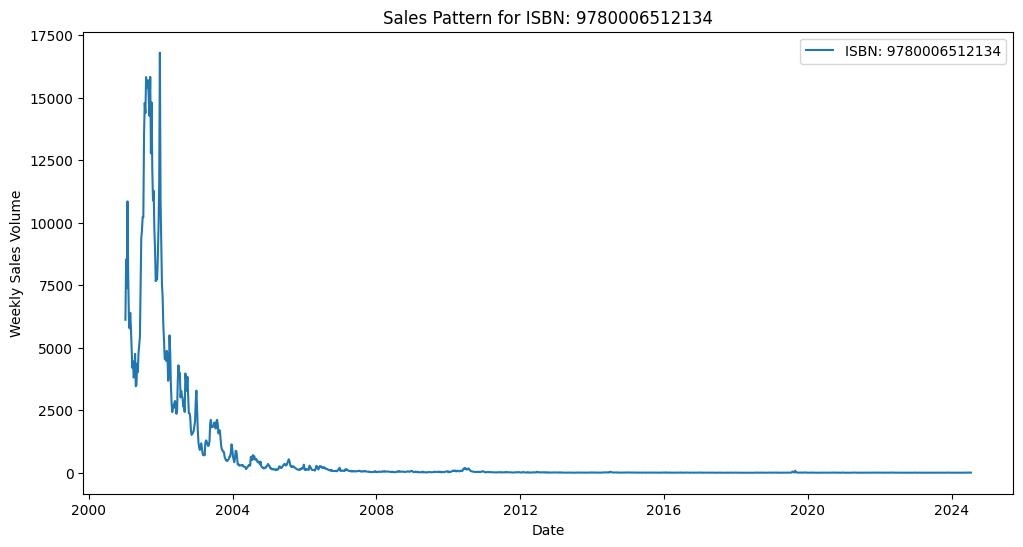

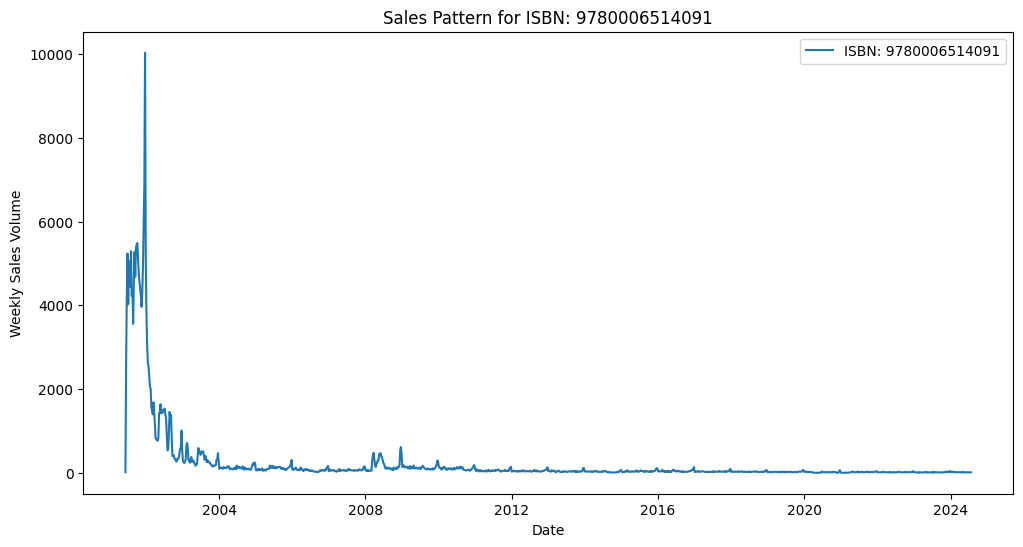

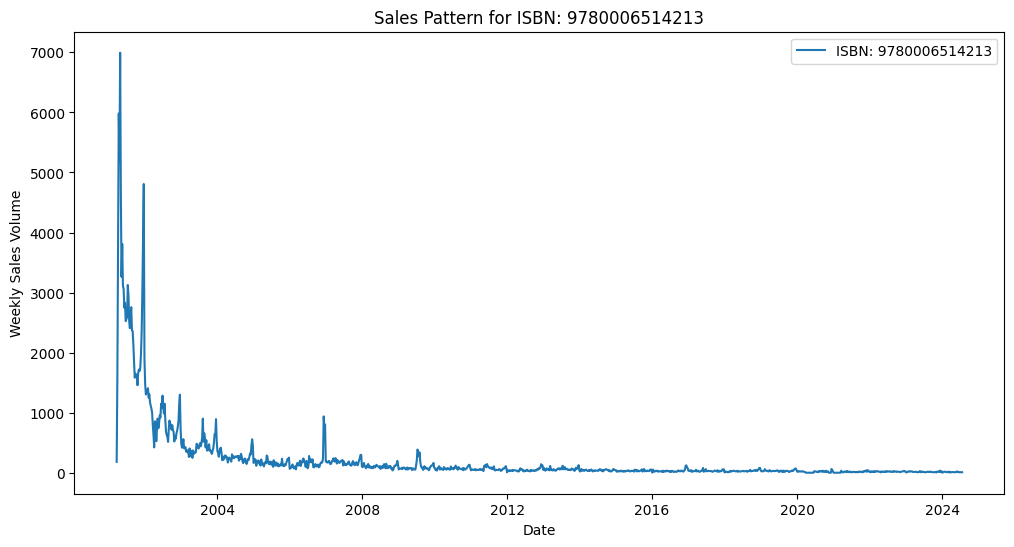

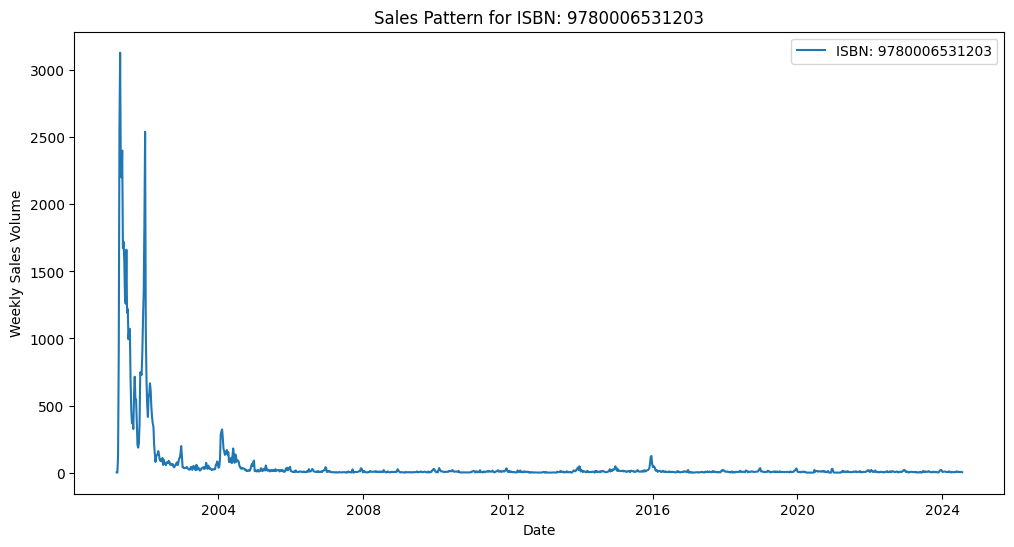

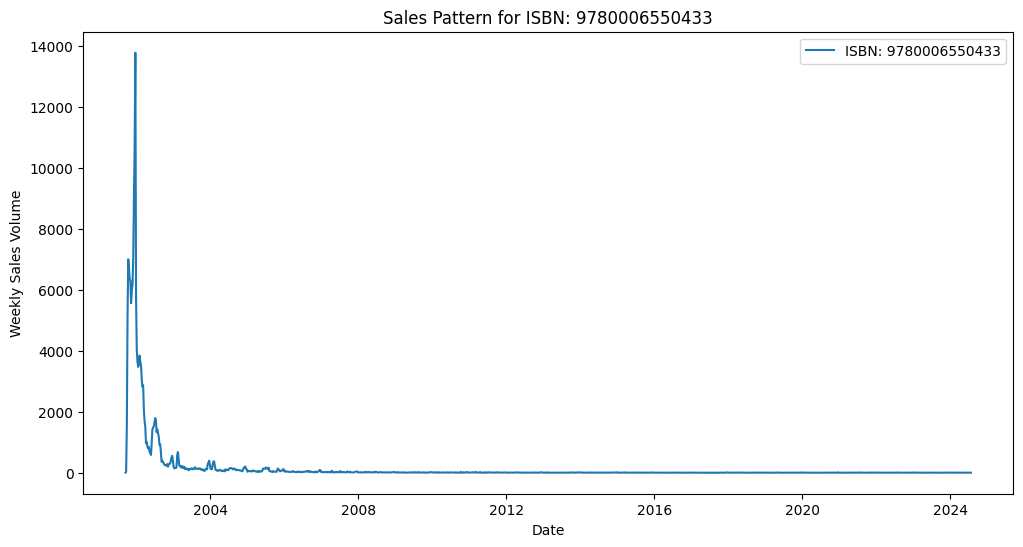

In [ ]:
# Path to save filtered sales data
filtered_sales_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/filtered_sales.pkl"

try:
    # Checking if filtered data already exists
    if os.path.exists(filtered_sales_path):
        print("Loading filtered sales data from file...")
        with open(filtered_sales_path, "rb") as f:
            sales_data_filtered = pickle.load(f)
    else:
        raise FileNotFoundError
except (FileNotFoundError, EOFError, pickle.UnpicklingError):
    print("Filtered sales data file not found. Filtering sales data...")

    # Defining the filter date
    filter_date = pd.Timestamp('2024-07-01')

    # Identifying ISBNs with future sales
    isbns_with_future_sales = sales_data_resampled[sales_data_resampled['End Date'] > filter_date]['ISBN'].unique()

    # Printing ISBNs with future sales for reporting
    print("ISBNs with sales data beyond 2024-07-01:")
    print(isbns_with_future_sales)

    # Filtering sales data to exclude rows with dates beyond 2024-07-01
    sales_data_filtered = sales_data_resampled[sales_data_resampled['End Date'] <= filter_date]

    # Saving the filtered sales data
    with open(filtered_sales_path, "wb") as f:
        pickle.dump(sales_data_filtered, f)
    print("Filtered sales data saved successfully.")

# Plotting sales data for ISBNs with future sales
filter_date = pd.Timestamp('2024-07-01')
isbns_with_future_sales = sales_data_resampled[sales_data_resampled['End Date'] > filter_date]['ISBN'].unique()

for i, isbn in enumerate(isbns_with_future_sales[:5]):  # Limit to 5 ISBNs
    sales_isbn = sales_data_resampled[sales_data_resampled['ISBN'] == isbn].sort_values(by='End Date')
    plt.figure(figsize=(12, 6))
    plt.plot(sales_isbn['End Date'], sales_isbn['Volume'], label=f"ISBN: {isbn}")
    plt.title(f"Sales Pattern for ISBN: {isbn}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales Volume")
    plt.legend()
    plt.show()

Most ISBNs saw peak sales in the early 2000s, likely due to new releases or heightened popularity at the time. Over time, sales declined and eventually stabilized at low levels, reflecting the typical lifecycle of books as demand wanes. Recent sales are minimal, suggesting these titles are no longer actively marketed or stocked.

Occasional sales spikes may be linked to events like movie adaptations or anniversaries. Additionally, the dataset may be biased toward older books, emphasizing trends from that era rather than current market dynamics.

### Handling Missing Values



In [ ]:
# Defining the ISBNs for The Alchemist and The Very Hungry Caterpillar
alchemist_isbn = "9780722532935"
caterpillar_isbn = "9780241003008"

# Filtering data for The Alchemist and The Very Hungry Caterpillar
filtered_books_data = sales_data_resampled[
    sales_data_resampled['ISBN'].isin([alchemist_isbn, caterpillar_isbn])
]

# Further filtering for dates > 2012-01-01
filtered_books_data = filtered_books_data[filtered_books_data['End Date'] > "2012-01-01"]

# Filling missing static fields using forward-fill (ffill) or backward-fill (bfill)
fields_to_fill = ['Title', 'Author', 'Binding', 'Imprint', 'Publisher Group', 'Product Class']
filtered_books_data[fields_to_fill] = filtered_books_data.groupby('ISBN')[fields_to_fill].transform(
    lambda group: group.ffill().bfill()
)

# Verifying the fixed filtered data
print("Filtered data for The Alchemist and The Very Hungry Caterpillar (both ISBNs):")
print(filtered_books_data.head())

# Checking for missing static fields
missing_static_fields = filtered_books_data[filtered_books_data['Title'].isnull()]
print("\nRows with missing static fields after filling:")
print(missing_static_fields)

Filtered data for The Alchemist and The Very Hungry Caterpillar (both ISBNs):
         End Date  Volume    Value                         Title       Author  \
102506 2012-01-08     512  2522.13  Very Hungry Caterpillar, The  Carle, Eric   
102507 2012-01-15     519  2473.31  Very Hungry Caterpillar, The  Carle, Eric   
102508 2012-01-22     574  2757.83  Very Hungry Caterpillar, The  Carle, Eric   
102509 2012-01-29     621  3072.66  Very Hungry Caterpillar, The  Carle, Eric   
102510 2012-02-05    1140  4724.18  Very Hungry Caterpillar, The  Carle, Eric   

         Binding       Imprint Publisher Group       Product Class  \
102506  Hardback  Puffin Books     Penguin Grp  Y1.3 Picture Books   
102507  Hardback  Puffin Books     Penguin Grp  Y1.3 Picture Books   
102508  Hardback  Puffin Books     Penguin Grp  Y1.3 Picture Books   
102509  Hardback  Puffin Books     Penguin Grp  Y1.3 Picture Books   
102510  Hardback  Puffin Books     Penguin Grp  Y1.3 Picture Books   

              


We've filtered all sales to only include *The Alchemist* and *The Very Hungry Caterpillar*
from 2012 onward. This narrower timeframe ensures our subsequent analysis and models
focus on recent trends and exclude older, potentially irrelevant patterns.


## Exploratory Data Analysis (EDA)

### Sales Trends & Seasonality

<Figure size 1200x800 with 0 Axes>

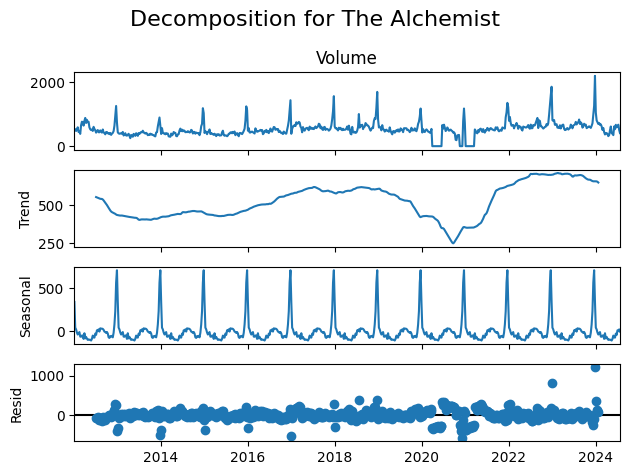

<Figure size 1200x800 with 0 Axes>

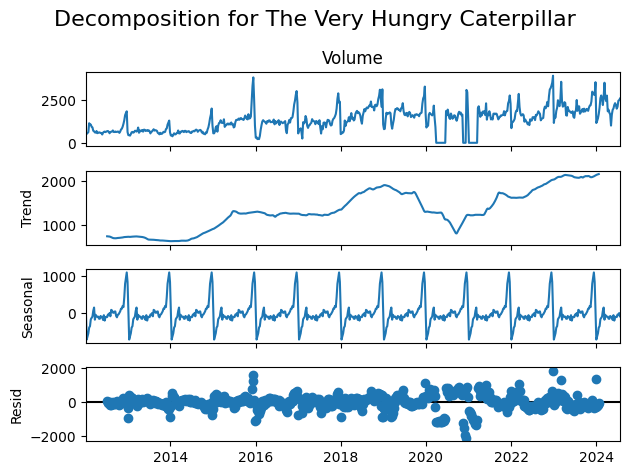

In [ ]:
# Filtering data for each book
alchemist_data = filtered_books_data[filtered_books_data['ISBN'] == "9780722532935"]
caterpillar_data = filtered_books_data[filtered_books_data['ISBN'] == "9780241003008"]

# Ensuring data is sorted by date
alchemist_data = alchemist_data.sort_values(by="End Date")
caterpillar_data = caterpillar_data.sort_values(by="End Date")

# Setting the time index for decomposition
alchemist_data = alchemist_data.set_index("End Date")
caterpillar_data = caterpillar_data.set_index("End Date")

# Performing decomposition
alchemist_decomp = seasonal_decompose(alchemist_data['Volume'], model='additive', period=52)
caterpillar_decomp = seasonal_decompose(caterpillar_data['Volume'], model='additive', period=52)

# Plotting the decomposition for The Alchemist
plt.figure(figsize=(12, 8))
alchemist_decomp.plot()
plt.suptitle("Decomposition for The Alchemist", fontsize=16, y=0.98)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# Plotting the decomposition for The Very Hungry Caterpillar
plt.figure(figsize=(12, 8))
caterpillar_decomp.plot()
plt.suptitle("Decomposition for The Very Hungry Caterpillar", fontsize=16, y=0.98)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


- *The Alchemist*: Exhibits a consistent annual seasonality with clear peaks, likely around the holiday season. The trend is relatively stable but experiences a dip around 2020 before recovering. The residuals remain mostly contained, suggesting that trend and seasonality explain most variations.

- *The Very Hungry Caterpillar*: Shows stronger long-term growth, with noticeable seasonal spikes. Like The Alchemist, it dips around 2020 before continuing its upward trend. However, its residuals are more pronounced, indicating fluctuations beyond simple seasonality, suggesting external factors or irregular demand surges.



### Autocorrelation Analysis (ACF & PACF)

ACF and PACF for The Alchemist:


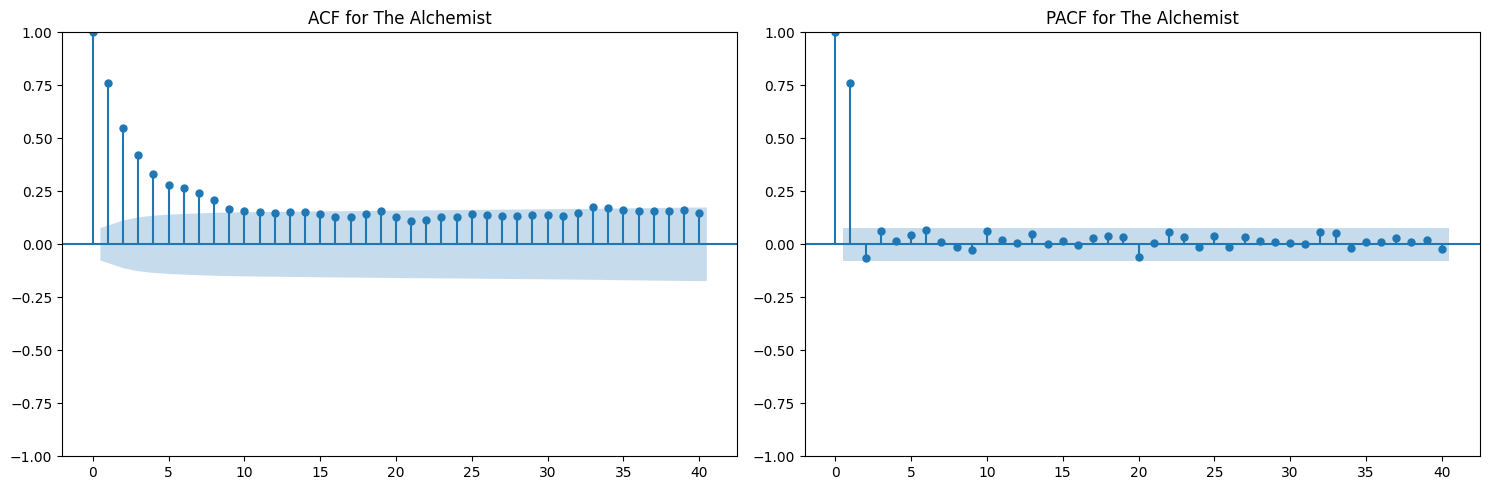

ACF and PACF for The Very Hungry Caterpillar:


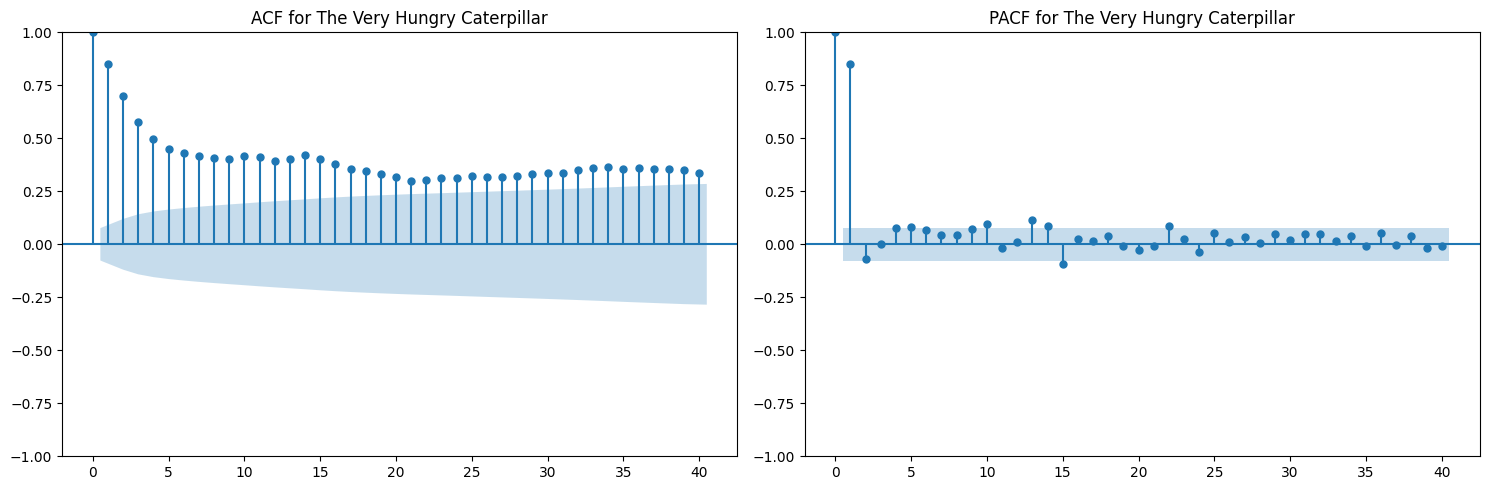

In [ ]:
# Function to plot ACF and PACF
def plot_acf_pacf(data, title, lags=40):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(data, lags=lags, ax=axes[0])
    axes[0].set_title(f"ACF for {title}")
    plot_pacf(data, lags=lags, ax=axes[1])
    axes[1].set_title(f"PACF for {title}")
    plt.tight_layout()
    plt.show()

# Plotting ACF and PACF for The Alchemist
print("ACF and PACF for The Alchemist:")
plot_acf_pacf(alchemist_data['Volume'], "The Alchemist")

# Plotting ACF and PACF for The Very Hungry Caterpillar
print("ACF and PACF for The Very Hungry Caterpillar:")
plot_acf_pacf(caterpillar_data['Volume'], "The Very Hungry Caterpillar")


- The gradual decay in ACF for both books confirms the presence of autocorrelation
  extending beyond a single lag.
- A sharp cutoff in the PACF after lag 1 suggests an AR(1) component may be sufficient
  to capture short-term dependencies, although each series also exhibits significant
  seasonality that we must handle separately.


### Stationarity Check (ADF Test)

In [ ]:
def check_stationarity(series, title):

    print(f"Performing ADF Test for {title}...")
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    if result[1] < 0.05:
        print(f"The data for {title} is stationary (p < 0.05).")
    else:
        print(f"The data for {title} is not stationary (p >= 0.05).")
    print("\n")

# Performing ADF Test for "The Alchemist" and "The Very Hungry Caterpillar"
check_stationarity(alchemist_data["Volume"], "The Alchemist")
check_stationarity(caterpillar_data["Volume"], "The Very Hungry Caterpillar")

Performing ADF Test for The Alchemist...
ADF Statistic: -8.295945282786748
p-value: 4.139950997174928e-13
Critical Values:
	1%: -3.440419374623044
	5%: -2.865983079837035
	10%: -2.5691361169972526
The data for The Alchemist is stationary (p < 0.05).


Performing ADF Test for The Very Hungry Caterpillar...
ADF Statistic: -3.060522521450634
p-value: 0.029616021527175844
Critical Values:
	1%: -3.4406089407081604
	5%: -2.866066583404541
	10%: -2.5691806079101562
The data for The Very Hungry Caterpillar is stationary (p < 0.05).




- **The Alchemist**: ADF statistic ≈ -8.30 (p < 0.05), indicating a strongly stationary series.
  This implies no additional differencing steps are strictly required for ARIMA-based models.
- **The Very Hungry Caterpillar**: ADF statistic ≈ -3.06 (p < 0.05), also stationary,
  albeit less decisively so. The series still justifies using ARIMA without further differencing,
  but its stronger seasonality and variance might warrant more careful validation.



## Classical Time Series Models

### SARIMA Model Selection (Auto ARIMA)

In [ ]:
# Suppressing FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Excluding the final 32 weeks of data for training
train_alchemist = alchemist_data.iloc[:-32]
test_alchemist = alchemist_data.iloc[-32:]

train_hungry_caterpillar = caterpillar_data.iloc[:-32]
test_hungry_caterpillar = caterpillar_data.iloc[-32:]

# Paths to save Auto ARIMA models
alchemist_arima_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/auto_arima_alchemist.pkl"
hungry_caterpillar_arima_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/auto_arima_hungry_caterpillar.pkl"

# Auto ARIMA for The Alchemist
if os.path.exists(alchemist_arima_path):
    print("Loading Auto ARIMA model for The Alchemist from file...")
    with open(alchemist_arima_path, "rb") as f:
        auto_arima_alchemist = pickle.load(f)
else:
    print("Fitting Auto ARIMA for The Alchemist...")
    auto_arima_alchemist = auto_arima(
        train_alchemist['Volume'],
        seasonal=True,
        m=52,
        max_p=2, max_q=2,
        max_P=2, max_Q=2,
        max_d=2, max_D=1,
        stepwise=True,
        trace=True,
        error_action="ignore",
        suppress_warnings=True
    )
    # Saving the fitted model
    with open(alchemist_arima_path, "wb") as f:
        pickle.dump(auto_arima_alchemist, f)
    print("Auto ARIMA model for The Alchemist saved.")

print("Best model for The Alchemist:")
print(auto_arima_alchemist.summary())

Loading Auto ARIMA model for The Alchemist from file...
Best model for The Alchemist:
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  623
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 52)   Log Likelihood               -3804.646
Date:                             Sun, 26 Jan 2025   AIC                           7623.292
Time:                                     18:17:05   BIC                           7654.322
Sample:                                 01-08-2012   HQIC                          7635.352
                                      - 12-10-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.015

In [ ]:
# Auto ARIMA for The Very Hungry Caterpillar
if os.path.exists(hungry_caterpillar_arima_path):
    print("\nLoading Auto ARIMA model for The Very Hungry Caterpillar from file...")
    with open(hungry_caterpillar_arima_path, "rb") as f:
        auto_arima_hungry_caterpillar = pickle.load(f)
else:
    print("\nFitting Auto ARIMA for The Very Hungry Caterpillar...")
    auto_arima_hungry_caterpillar = auto_arima(
        train_hungry_caterpillar['Volume'],
        seasonal=True,
        m=52,
        max_p=2, max_q=2,
        max_P=2, max_Q=2,
        max_d=2, max_D=1,
        stepwise=True,
        trace=True,
        error_action="ignore",
        suppress_warnings=True
    )
    # Saving the fitted model
    with open(hungry_caterpillar_arima_path, "wb") as f:
        pickle.dump(auto_arima_hungry_caterpillar, f)
    print("Auto ARIMA model for The Very Hungry Caterpillar saved.")

print("\nBest model for The Very Hungry Caterpillar:")
print(auto_arima_hungry_caterpillar.summary())


Loading Auto ARIMA model for The Very Hungry Caterpillar from file...

Best model for The Very Hungry Caterpillar:
                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  623
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2], 52)   Log Likelihood               -4482.094
Date:                                 Sun, 26 Jan 2025   AIC                           8978.188
Time:                                         18:17:17   BIC                           9009.219
Sample:                                     01-08-2012   HQIC                          8990.248
                                          - 12-10-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

- *The Alchemist*: SARIMAX(1,1,2)x(2,0,[],52) demonstrates a strong AR(1) component and
  seasonal AR terms, capturing year-to-year dependencies. The relatively low AIC (≈7623)
  suggests a decent fit, though residual tests indicate some heteroskedasticity.
- *The Very Hungry Caterpillar*: SARIMAX(2,1,1)x(1,0,[1,2],52) also fits its yearly cycle.
  However, a higher AIC (≈8978) and more pronounced residual variance point to greater
  volatility that the model struggles to fully capture.

### Residual Analysis & Model Diagnostics

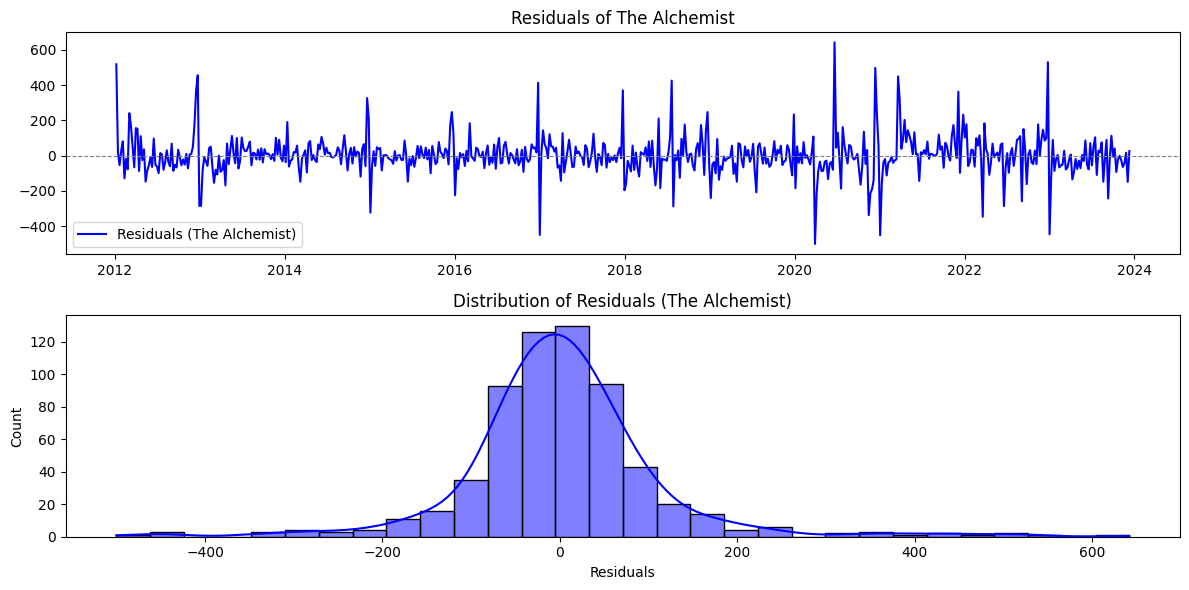

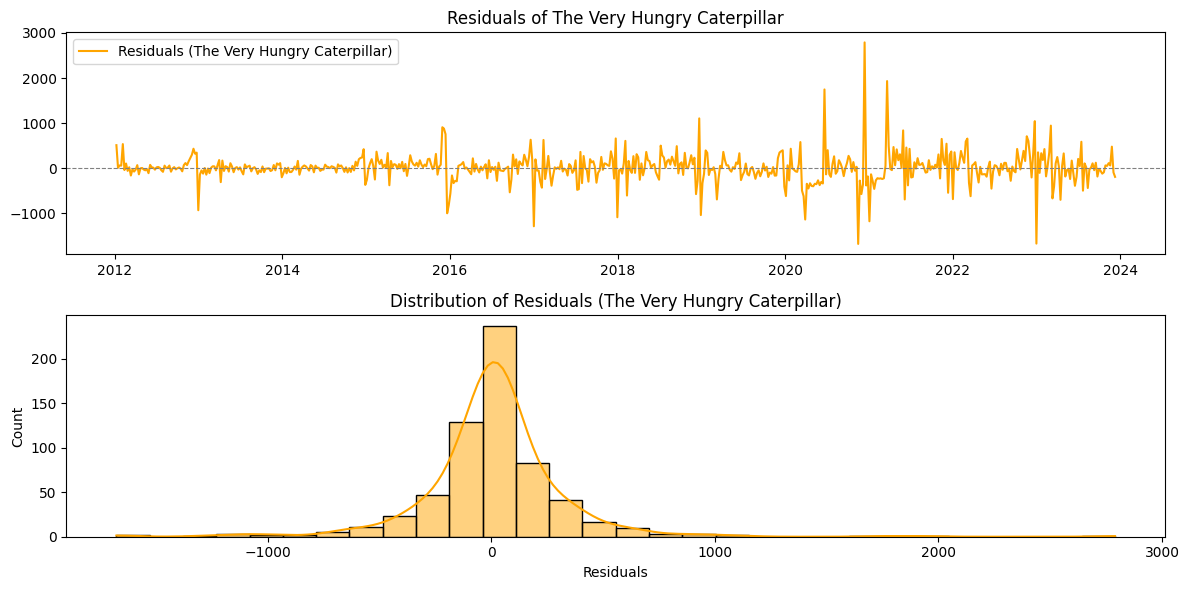

In [ ]:
# Extracting residuals from the fitted Auto ARIMA models
residuals_alchemist = auto_arima_alchemist.resid()
residuals_hungry_caterpillar = auto_arima_hungry_caterpillar.resid()

# Plotting the residuals for The Alchemist
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals_alchemist, label="Residuals (The Alchemist)", color="blue")
plt.axhline(0, linestyle="--", color="gray", linewidth=0.8)
plt.title("Residuals of The Alchemist")
plt.legend()

# Residuals distribution for The Alchemist
plt.subplot(2, 1, 2)
sns.histplot(residuals_alchemist, kde=True, color="blue", bins=30)
plt.title("Distribution of Residuals (The Alchemist)")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

# Plotting the residuals for The Very Hungry Caterpillar
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals_hungry_caterpillar, label="Residuals (The Very Hungry Caterpillar)", color="orange")
plt.axhline(0, linestyle="--", color="gray", linewidth=0.8)
plt.title("Residuals of The Very Hungry Caterpillar")
plt.legend()

# Residuals distribution for The Very Hungry Caterpillar
plt.subplot(2, 1, 2)
sns.histplot(residuals_hungry_caterpillar, kde=True, color="orange", bins=30)
plt.title("Distribution of Residuals (The Very Hungry Caterpillar)")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


In both series, residuals mostly cluster around zero, suggesting the models capture
much of the systematic pattern. However, the spikes in *The Very Hungry Caterpillar*
residuals—especially during 2020—reflect events the model can't easily forecast. For
practical forecasting, this tells us the model is generally reliable but may underpredict
during sudden surges.


### Forecasting & Performance Evaluation


The Alchemist - MAE: 155.0836, MAPE: 0.2976
The Very Hungry Caterpillar - MAE: 353.1417, MAPE: 0.1863


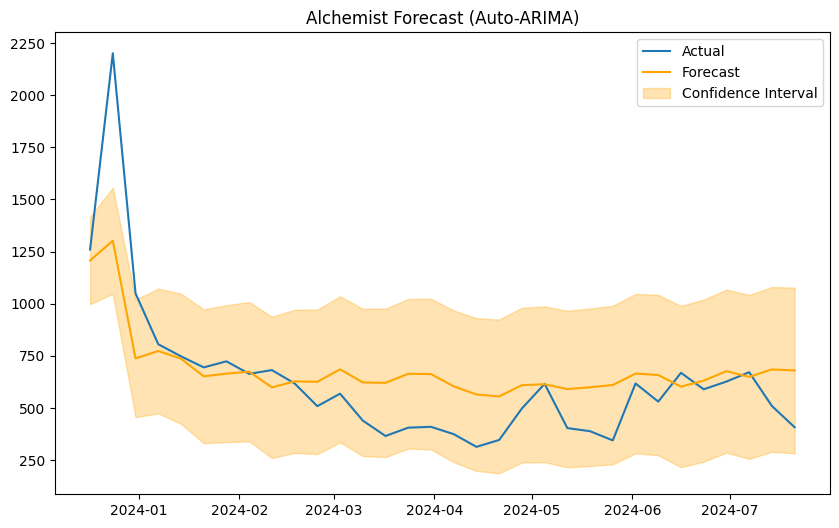

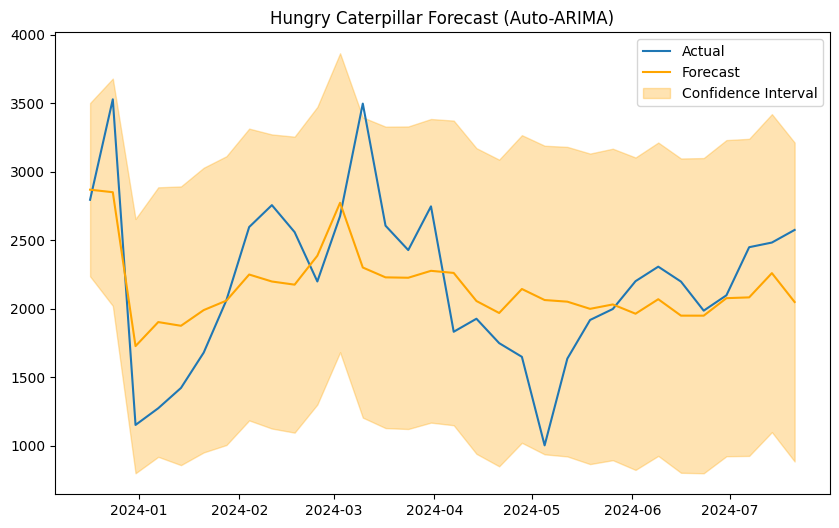

In [ ]:
# Defining the forecast horizon
forecast_horizon = 32

# Preparing to store predictions and confidence intervals
forecast_results = {}

# Forecasting for The Alchemist
alchemist_forecast = auto_arima_alchemist.predict(n_periods=forecast_horizon, return_conf_int=True)
alchemist_forecast_mean = alchemist_forecast[0]
alchemist_forecast_conf_int = alchemist_forecast[1]

# Forecasting for The Very Hungry Caterpillar
vhc_forecast = auto_arima_hungry_caterpillar.predict(n_periods=forecast_horizon, return_conf_int=True)
vhc_forecast_mean = vhc_forecast[0]
vhc_forecast_conf_int = vhc_forecast[1]

# Calculate MAE and MAPE for The Alchemist
alchemist_mae = mean_absolute_error(test_alchemist['Volume'], alchemist_forecast_mean)
alchemist_mape = mean_absolute_percentage_error(test_alchemist['Volume'], alchemist_forecast_mean)

# Calculate MAE and MAPE for The Very Hungry Caterpillar
vhc_mae = mean_absolute_error(test_hungry_caterpillar['Volume'], vhc_forecast_mean)
vhc_mape = mean_absolute_percentage_error(test_hungry_caterpillar['Volume'], vhc_forecast_mean)

# Display MAE and MAPE
print(f"The Alchemist - MAE: {alchemist_mae:.4f}, MAPE: {alchemist_mape:.4f}")
print(f"The Very Hungry Caterpillar - MAE: {vhc_mae:.4f}, MAPE: {vhc_mape:.4f}")

# Plotting for The Alchemist
plt.figure(figsize=(10, 6))
plt.plot(test_alchemist.index, test_alchemist['Volume'], label="Actual")
plt.plot(pd.date_range(start=test_alchemist.index[0], periods=forecast_horizon, freq='W'),
         alchemist_forecast_mean, label="Forecast", color="orange")
plt.fill_between(pd.date_range(start=test_alchemist.index[0], periods=forecast_horizon, freq='W'),
                 alchemist_forecast_conf_int[:, 0], alchemist_forecast_conf_int[:, 1],
                 color='orange', alpha=0.3, label="Confidence Interval")
plt.title("Alchemist Forecast (Auto-ARIMA)")
plt.legend()
plt.show()

# Plotting for The Very Hungry Caterpillar
plt.figure(figsize=(10, 6))
plt.plot(test_hungry_caterpillar.index, test_hungry_caterpillar['Volume'], label="Actual")
plt.plot(pd.date_range(start=test_hungry_caterpillar.index[0], periods=forecast_horizon, freq='W'),
         vhc_forecast_mean, label="Forecast", color="orange")
plt.fill_between(pd.date_range(start=test_hungry_caterpillar.index[0], periods=forecast_horizon, freq='W'),
                 vhc_forecast_conf_int[:, 0], vhc_forecast_conf_int[:, 1],
                 color='orange', alpha=0.3, label="Confidence Interval")
plt.title("Hungry Caterpillar Forecast (Auto-ARIMA)")
plt.legend()
plt.show()



- *The Alchemist*: MAE ≈ 155; MAPE ≈ 30%  
  Good at broader trends, but tends to miss sudden dips or rebounds.
- *The Very Hungry Caterpillar*: MAE ≈ 353; MAPE ≈ 19%  
  Captures the general upward pattern, though large spikes push the absolute error higher.

Overall, both models cover the main seasonal and trend elements but may underestimate
short-term extremes. This aligns with the residual plots showing that pandemic-related
shocks or promotional spikes can exceed what SARIMA alone can handle.

## Machine Learning Approach




### Feature Engineering for XGBoost


In [ ]:
# Function to create supervised learning features
def create_supervised_features(data, lag=1):

    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df_supervised = pd.concat(columns, axis=1)
    df_supervised.columns = ['Lag_' + str(i) for i in range(1, lag + 1)] + ['Target']
    df_supervised.dropna(inplace=True)
    return df_supervised

# Defining the number of lagged features
lag_features = 4

# Preparing data for The Alchemist
alchemist_supervised = create_supervised_features(train_alchemist['Volume'], lag=lag_features)
alchemist_train_X = alchemist_supervised.iloc[:, :-1]
alchemist_train_y = alchemist_supervised.iloc[:, -1]

# Preparing data for The Very Hungry Caterpillar
caterpillar_supervised = create_supervised_features(train_hungry_caterpillar['Volume'], lag=lag_features)
caterpillar_train_X = caterpillar_supervised.iloc[:, :-1]
caterpillar_train_y = caterpillar_supervised.iloc[:, -1]

# Verifying shapes
print("Alchemist Train Features Shape:", alchemist_train_X.shape)
print("Alchemist Train Target Shape:", alchemist_train_y.shape)
print("\nCaterpillar Train Features Shape:", caterpillar_train_X.shape)
print("Caterpillar Train Target Shape:", caterpillar_train_y.shape)

Alchemist Train Features Shape: (619, 4)
Alchemist Train Target Shape: (619,)

Caterpillar Train Features Shape: (619, 4)
Caterpillar Train Target Shape: (619,)


### Cross-Validation & Hyperparameter Tuning


In [ ]:
def time_series_cv(model, X, y, n_splits=5):
    """
    Perform manual time series cross-validation.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        score = mean_absolute_error(y_test, predictions)
        scores.append(score)

    return np.mean(scores), np.std(scores)

# Defining the XGBoost model
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

# Performing cross-validation for The Alchemist
alchemist_cv_mean, alchemist_cv_std = time_series_cv(xgb_model, alchemist_train_X, alchemist_train_y)
print(f"Cross-Validation MAE for The Alchemist (XGBoost): {alchemist_cv_mean:.4f} ± {alchemist_cv_std:.4f}")

# Performing cross-validation for The Very Hungry Caterpillar
caterpillar_cv_mean, caterpillar_cv_std = time_series_cv(xgb_model, caterpillar_train_X, caterpillar_train_y)
print(f"Cross-Validation MAE for The Very Hungry Caterpillar(XGBoost): {caterpillar_cv_mean:.4f} ± {caterpillar_cv_std:.4f}")


Cross-Validation MAE for The Alchemist (XGBoost): 98.0450 ± 31.5188
Cross-Validation MAE for The Very Hungry Caterpillar(XGBoost): 308.2207 ± 53.9119


In [ ]:
def hyperparameter_tuning_with_window_length(data, param_grid, n_splits=5, model_path=None):

    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_model = None
    best_score = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        # Extracting window_length and remove it from params for the XGB model
        window_length = params.pop('window_length')

        scores = []
        for train_index, val_index in tscv.split(data):
            # Splitting data into train and validation sets
            train_data, val_data = data.iloc[train_index], data.iloc[val_index]

            # Transforming data based on current window_length
            train_transformed = create_supervised_features(train_data, lag=window_length)
            val_transformed = create_supervised_features(val_data, lag=window_length)

            # Separating features and target
            X_train, y_train = train_transformed.iloc[:, :-1], train_transformed.iloc[:, -1]
            X_val, y_val = val_transformed.iloc[:, :-1], val_transformed.iloc[:, -1]

            # Training the model with the current parameters
            model = XGBRegressor(objective='reg:squarederror', **params, random_state=42)
            model.fit(X_train, y_train)
            predictions = model.predict(X_val)

            # Calculating the mean absolute error
            score = mean_absolute_error(y_val, predictions)
            scores.append(score)

        # Calculating mean score across all folds
        mean_score = np.mean(scores)
        if mean_score < best_score:
            best_model = model
            best_score = mean_score
            best_params = {**params, 'window_length': window_length}

    # Saving the best model
    if model_path:
        with open(model_path, "wb") as f:
            pickle.dump(best_model, f)

    return best_model, best_params, best_score


In [ ]:
# Defining parameter grid, including window_length
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'window_length': [4, 8, 12]
}

# Paths to save best parameters
alchemist_params_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/xgb_alchemist_params_with_lag.pkl"
caterpillar_params_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/xgb_caterpillar_params_with_lag.pkl"

# Hyperparameter tuning for The Alchemist
if os.path.exists(alchemist_params_path):
    print("Loading best parameters for The Alchemist...")
    with open(alchemist_params_path, "rb") as f:
        best_alchemist_params = pickle.load(f)
else:
    print("Tuning hyperparameters for The Alchemist...")
    _, best_alchemist_params, alchemist_score = hyperparameter_tuning_with_window_length(
        train_alchemist['Volume'], param_grid
    )
    # Saving the best parameters
    with open(alchemist_params_path, "wb") as f:
        pickle.dump(best_alchemist_params, f)
    print(f"Best Parameters for The Alchemist: {best_alchemist_params}")
    print(f"Validation MAE: {alchemist_score:.4f}")

# Output the best hyperparameters for The Alchemist
print("\nBest Hyperparameters for The Alchemist:")
for key, value in best_alchemist_params.items():
    print(f"  {key}: {value}")

# Hyperparameter tuning for The Very Hungry Caterpillar
if os.path.exists(caterpillar_params_path):
    print("\nLoading best parameters for The Very Hungry Caterpillar...")
    with open(caterpillar_params_path, "rb") as f:
        best_caterpillar_params = pickle.load(f)
else:
    print("\nTuning hyperparameters for The Very Hungry Caterpillar...")
    _, best_caterpillar_params, caterpillar_score = hyperparameter_tuning_with_window_length(
        train_hungry_caterpillar['Volume'], param_grid
    )
    # Saving the best parameters
    with open(caterpillar_params_path, "wb") as f:
        pickle.dump(best_caterpillar_params, f)
    print(f"Best Parameters for The Very Hungry Caterpillar: {best_caterpillar_params}")
    print(f"Validation MAE: {caterpillar_score:.4f}")

# Output the best hyperparameters for The Very Hungry Caterpillar
print("\nBest Hyperparameters for The Very Hungry Caterpillar:")
for key, value in best_caterpillar_params.items():
    print(f"  {key}: {value}")



Loading best parameters for The Alchemist...

Best Hyperparameters for The Alchemist:
  learning_rate: 0.2
  max_depth: 3
  n_estimators: 50
  window_length: 4

Loading best parameters for The Very Hungry Caterpillar...

Best Hyperparameters for The Very Hungry Caterpillar:
  learning_rate: 0.2
  max_depth: 3
  n_estimators: 50
  window_length: 4


In [ ]:
# Paths to save final models
final_alchemist_model_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/xgb_alchemist_final.pkl"
final_caterpillar_model_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/xgb_caterpillar_final.pkl"

# Loading or training the final model for The Alchemist
if os.path.exists(final_alchemist_model_path):
    print("Loading final model for The Alchemist...")
    with open(final_alchemist_model_path, "rb") as f:
        final_alchemist_model = pickle.load(f)
else:
    print("Training final model for The Alchemist...")
    # Generating lagged features
    alchemist_train_transformed = create_supervised_features(
        train_alchemist['Volume'], lag=best_alchemist_params['window_length']
    )
    # Separating features and target
    alchemist_X_train = alchemist_train_transformed.iloc[:, :-1]
    alchemist_y_train = alchemist_train_transformed.iloc[:, -1]

    # Training the model
    final_alchemist_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_alchemist_params)
    final_alchemist_model.fit(alchemist_X_train, alchemist_y_train)

    # Saving the model
    with open(final_alchemist_model_path, "wb") as f:
        pickle.dump(final_alchemist_model, f)
    print("Final model for The Alchemist trained and saved.")

# Loading or training the final model for The Very Hungry Caterpillar
if os.path.exists(final_caterpillar_model_path):
    print("Loading final model for The Very Hungry Caterpillar...")
    with open(final_caterpillar_model_path, "rb") as f:
        final_caterpillar_model = pickle.load(f)
else:
    print("Training final model for The Very Hungry Caterpillar...")
    # Generating lagged features
    caterpillar_train_transformed = create_supervised_features(
        train_hungry_caterpillar['Volume'], lag=best_caterpillar_params['window_length']
    )
    # Separating features and target
    caterpillar_X_train = caterpillar_train_transformed.iloc[:, :-1]
    caterpillar_y_train = caterpillar_train_transformed.iloc[:, -1]

    # Training the model
    final_caterpillar_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_caterpillar_params)
    final_caterpillar_model.fit(caterpillar_X_train, caterpillar_y_train)

    # Saving the model
    with open(final_caterpillar_model_path, "wb") as f:
        pickle.dump(final_caterpillar_model, f)
    print("Final model for The Very Hungry Caterpillar trained and saved.")

Loading final model for The Alchemist...
Loading final model for The Very Hungry Caterpillar...


### XGBoost Forecasting & Evaluation

In [ ]:
# Ensuring the test data is prepared with the same window_length as training
alchemist_test_transformed = create_supervised_features(
    test_alchemist['Volume'], lag=best_alchemist_params['window_length']
)
caterpillar_test_transformed = create_supervised_features(
    test_hungry_caterpillar['Volume'], lag=best_caterpillar_params['window_length']
)

# Separating features (X) for forecasting
alchemist_X_test = alchemist_test_transformed.iloc[:, :-1]
caterpillar_X_test = caterpillar_test_transformed.iloc[:, :-1]

# Forecasting for both books
alchemist_predictions = final_alchemist_model.predict(alchemist_X_test)
caterpillar_predictions = final_caterpillar_model.predict(caterpillar_X_test)

The Alchemist (XGBoost) - MAE: 94.989501953125 , MAPE: 0.1901630461215973
The Very Hungry Caterpillar (XGBoost) - MAE: 360.2436218261719 , MAPE: 0.16869165003299713


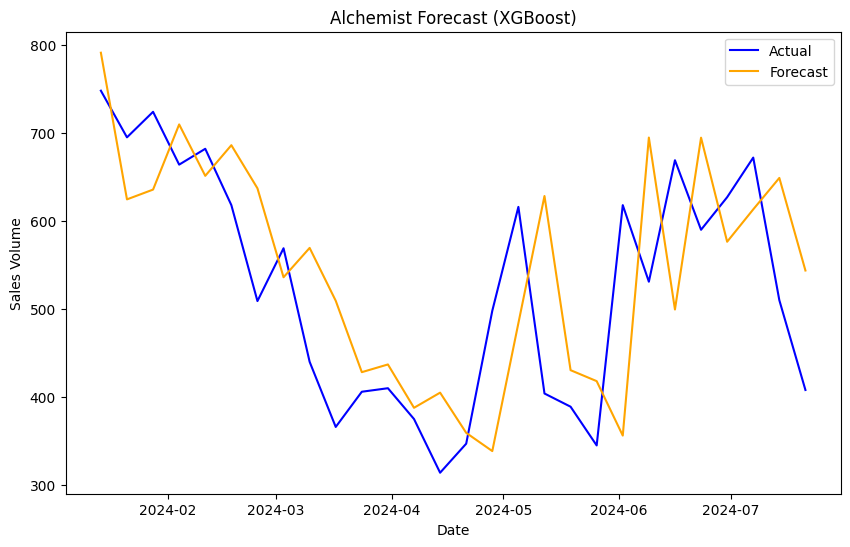

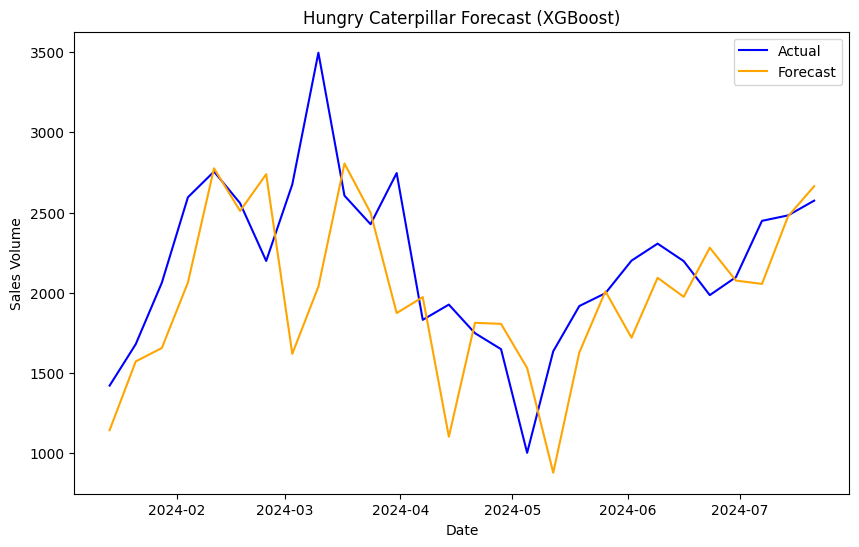

In [ ]:
# Calculating evaluation metrics
alchemist_mae = mean_absolute_error(test_alchemist['Volume'][-len(alchemist_predictions):], alchemist_predictions)
alchemist_mape = mean_absolute_percentage_error(test_alchemist['Volume'][-len(alchemist_predictions):], alchemist_predictions)

caterpillar_mae = mean_absolute_error(test_hungry_caterpillar['Volume'][-len(caterpillar_predictions):], caterpillar_predictions)
caterpillar_mape = mean_absolute_percentage_error(test_hungry_caterpillar['Volume'][-len(caterpillar_predictions):], caterpillar_predictions)

print("The Alchemist (XGBoost) - MAE:", alchemist_mae, ", MAPE:", alchemist_mape)
print("The Very Hungry Caterpillar (XGBoost) - MAE:", caterpillar_mae, ", MAPE:", caterpillar_mape)

# Aligning actual values with transformed test data
aligned_actual_alchemist = test_alchemist['Volume'][-len(alchemist_test_transformed):]
aligned_actual_caterpillar = test_hungry_caterpillar['Volume'][-len(caterpillar_test_transformed):]

# Plotting for The Alchemist
plt.figure(figsize=(10, 6))
plt.plot(aligned_actual_alchemist.index, aligned_actual_alchemist, label="Actual", color="blue")
plt.plot(aligned_actual_alchemist.index, alchemist_predictions, label="Forecast", color="orange")
plt.title("Alchemist Forecast (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.legend()
plt.show()

# Plotting for The Very Hungry Caterpillar
plt.figure(figsize=(10, 6))
plt.plot(aligned_actual_caterpillar.index, aligned_actual_caterpillar, label="Actual", color="blue")
plt.plot(aligned_actual_caterpillar.index, caterpillar_predictions, label="Forecast", color="orange")
plt.title("Hungry Caterpillar Forecast (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.legend()
plt.show()


- *The Alchemist*: XGBoost achieves MAE ≈ 95 and MAPE ≈ 19%, improving on the Auto ARIMA
  model’s ~30% error. It handles moderate week-to-week fluctuations well.
- *The Very Hungry Caterpillar*: Despite a higher absolute MAE (≈360), the relative error
  (≈17% MAPE) is better than SARIMA’s ~19%. The strong upward trend and occasional spikes
  remain partly under-forecasted, but overall performance still outperforms SARIMA.

## Deep Learning Approach

### LSTM Model Design & Training


In [ ]:
# Paths to save scalers
scaler_alchemist_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/scaler_alchemist.pkl"
scaler_caterpillar_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/scaler_caterpillar.pkl"

# Defining window lengths
alchemist_window_length = 4
caterpillar_window_length = 4

# Function to prepare LSTM data
def prepare_lstm_data(data, window_length):

    X, y = [], []
    for i in range(window_length, len(data)):
        X.append(data[i - window_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Loading or fitting scalers for The Alchemist
if not os.path.exists(scaler_alchemist_path):
    scaler_alchemist = MinMaxScaler()
    scaler_alchemist.fit(train_alchemist[['Volume']])
    with open(scaler_alchemist_path, "wb") as f:
        pickle.dump(scaler_alchemist, f)
else:
    with open(scaler_alchemist_path, "rb") as f:
        scaler_alchemist = pickle.load(f)

# Loading or fitting scalers for The Very Hungry Caterpillar
if not os.path.exists(scaler_caterpillar_path):
    scaler_caterpillar = MinMaxScaler()
    scaler_caterpillar.fit(train_hungry_caterpillar[['Volume']])
    with open(scaler_caterpillar_path, "wb") as f:
        pickle.dump(scaler_caterpillar, f)
else:
    with open(scaler_caterpillar_path, "rb") as f:
        scaler_caterpillar = pickle.load(f)

# Scaling training and test data
train_alchemist_scaled = scaler_alchemist.transform(train_alchemist[['Volume']])
test_alchemist_scaled = scaler_alchemist.transform(test_alchemist[['Volume']])
train_caterpillar_scaled = scaler_caterpillar.transform(train_hungry_caterpillar[['Volume']])
test_caterpillar_scaled = scaler_caterpillar.transform(test_hungry_caterpillar[['Volume']])

# Preparing LSTM data
alchemist_X, alchemist_y = prepare_lstm_data(train_alchemist_scaled, alchemist_window_length)
alchemist_X_test, alchemist_y_test = prepare_lstm_data(test_alchemist_scaled, alchemist_window_length)

caterpillar_X, caterpillar_y = prepare_lstm_data(train_caterpillar_scaled, caterpillar_window_length)
caterpillar_X_test, caterpillar_y_test = prepare_lstm_data(test_caterpillar_scaled, caterpillar_window_length)

# Reshaping data for LSTM
alchemist_X = alchemist_X.reshape((alchemist_X.shape[0], alchemist_X.shape[1], 1))
alchemist_X_test = alchemist_X_test.reshape((alchemist_X_test.shape[0], alchemist_X_test.shape[1], 1))
caterpillar_X = caterpillar_X.reshape((caterpillar_X.shape[0], caterpillar_X.shape[1], 1))
caterpillar_X_test = caterpillar_X_test.reshape((caterpillar_X_test.shape[0], caterpillar_X_test.shape[1], 1))

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


We apply a MinMaxScaler to normalise weekly sales, enabling the LSTM to learn more
efficiently from values within a consistent range (typically 0 to 1). The subsequent
reshaping steps (samples, timesteps, features) align data with LSTM’s required 3D input format.

### Hyperparameter Optimisation (Keras Tuner)

In [ ]:
# Paths to save the best hyperparameters
alchemist_hyperparams_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_alchemist_hyperparams.pkl"
caterpillar_hyperparams_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_caterpillar_hyperparams.pkl"

# Defining the model builder for KerasTuner
def lstm_model_builder(hp, input_shape):
    model = Sequential([
        LSTM(
            units=hp.Int("units", min_value=32, max_value=128, step=16),
            activation="relu",
            input_shape=input_shape
        ),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4])),
        loss="mse"
    )
    return model

# Loading or tune hyperparameters for The Alchemist
if not os.path.exists(alchemist_hyperparams_path):
    print("Tuning hyperparameters for The Alchemist...")
    alchemist_tuner = Hyperband(
        lambda hp: lstm_model_builder(hp, input_shape=(alchemist_window_length, 1)),
        objective="val_loss",
        max_epochs=50,
        factor=3,
        directory="lstm_tuning",
        project_name="alchemist"
    )
    alchemist_tuner.search(
        alchemist_X, alchemist_y,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=1
    )
    best_alchemist_hps = alchemist_tuner.get_best_hyperparameters(num_trials=1)[0].values
    # Saving the best hyperparameters for future use
    with open(alchemist_hyperparams_path, "wb") as f:
        pickle.dump(best_alchemist_hps, f)
    print("Best hyperparameters for The Alchemist saved.")
else:
    print("Loading best hyperparameters for The Alchemist...")
    with open(alchemist_hyperparams_path, "rb") as f:
        best_alchemist_hps = pickle.load(f)

# Loading or tune hyperparameters for The Very Hungry Caterpillar
if not os.path.exists(caterpillar_hyperparams_path):
    print("Tuning hyperparameters for The Very Hungry Caterpillar...")
    caterpillar_tuner = Hyperband(
        lambda hp: lstm_model_builder(hp, input_shape=(caterpillar_window_length, 1)),
        objective="val_loss",
        max_epochs=50,
        factor=3,
        directory="lstm_tuning",
        project_name="caterpillar"
    )
    caterpillar_tuner.search(
        caterpillar_X, caterpillar_y,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=1
    )
    best_caterpillar_hps = caterpillar_tuner.get_best_hyperparameters(num_trials=1)[0].values
    # Saving the best hyperparameters for future use
    with open(caterpillar_hyperparams_path, "wb") as f:
        pickle.dump(best_caterpillar_hps, f)
    print("Best hyperparameters for The Very Hungry Caterpillar saved.")
else:
    print("Loading best hyperparameters for The Very Hungry Caterpillar...")
    with open(caterpillar_hyperparams_path, "rb") as f:
        best_caterpillar_hps = pickle.load(f)

# Printing the best hyperparameters for both books
print("\nBest hyperparameters for The Alchemist:")
for param, value in best_alchemist_hps.items():
    if not param.startswith("tuner/"):
        print(f"  {param}: {value}")

print("\nBest hyperparameters for The Very Hungry Caterpillar:")
for param, value in best_caterpillar_hps.items():
    if not param.startswith("tuner/"):
        print(f"  {param}: {value}")


Loading best hyperparameters for The Alchemist...
Loading best hyperparameters for The Very Hungry Caterpillar...

Best hyperparameters for The Alchemist:
  units: 128
  learning_rate: 0.001
  window_length: 8
  score: 0.008480518124997616

Best hyperparameters for The Very Hungry Caterpillar:
  units: 112
  learning_rate: 0.001
  window_length: 8
  score: 0.013860821723937988


In [ ]:
# Paths to save models
alchemist_model_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_alchemist_model.h5"
caterpillar_model_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_caterpillar_model.h5"

# Training or loading the model for The Alchemist
if not os.path.exists(alchemist_model_path):
    print("Training LSTM model for The Alchemist...")
    alchemist_model = Sequential([
        LSTM(units=best_alchemist_hps["units"], activation="relu", input_shape=(alchemist_window_length, 1)),
        Dense(1)
    ])
    alchemist_model.compile(optimizer=Adam(learning_rate=best_alchemist_hps["learning_rate"]), loss=MeanSquaredError())
    alchemist_model.fit(alchemist_X, alchemist_y, epochs=50, batch_size=32, verbose=1)
    alchemist_model.save(alchemist_model_path)
    print("Model for The Alchemist trained and saved.")
else:
    print("Loading saved LSTM model for The Alchemist...")
    alchemist_model = load_model(alchemist_model_path)

# Training or loading the model for The Very Hungry Caterpillar
if not os.path.exists(caterpillar_model_path):
    print("Training LSTM model for The Very Hungry Caterpillar...")
    caterpillar_model = Sequential([
        LSTM(units=best_caterpillar_hps["units"], activation="relu", input_shape=(caterpillar_window_length, 1)),
        Dense(1)
    ])
    caterpillar_model.compile(optimizer=Adam(learning_rate=best_caterpillar_hps["learning_rate"]), loss=MeanSquaredError())
    caterpillar_model.fit(caterpillar_X, caterpillar_y, epochs=50, batch_size=32, verbose=1)
    caterpillar_model.save(caterpillar_model_path)
    print("Model for The Very Hungry Caterpillar trained and saved.")
else:
    print("Loading saved LSTM model for The Very Hungry Caterpillar...")
    caterpillar_model = load_model(caterpillar_model_path)



Loading saved LSTM model for The Alchemist...


Loading saved LSTM model for The Very Hungry Caterpillar...


### Forecasting & Performance Metrics


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
The Alchemist (LSTM)- MAE: 77.69852447509766, MAPE: 0.15237390995025635
The Very Hungry Caterpillar (LSTM)- MAE: 314.93695068359375, MAPE: 0.1521455943584442


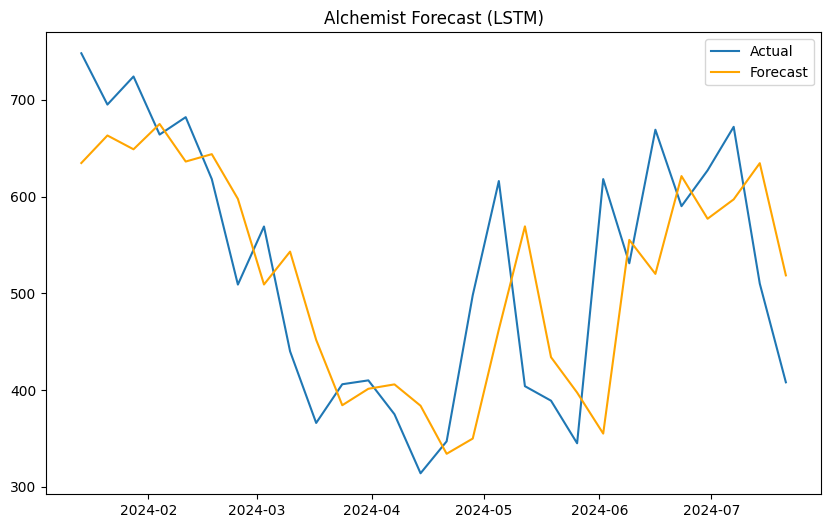

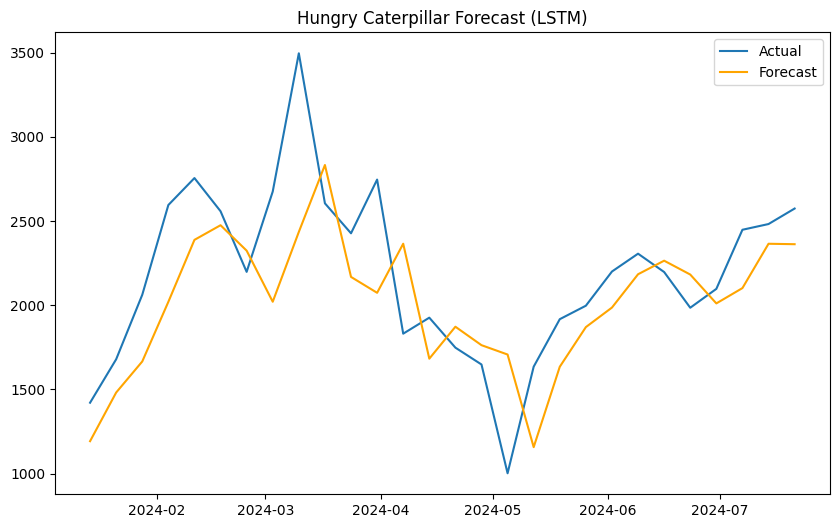

In [ ]:
# Making predictions
alchemist_predictions = alchemist_model.predict(alchemist_X_test)
alchemist_predictions = scaler_alchemist.inverse_transform(alchemist_predictions)

caterpillar_predictions = caterpillar_model.predict(caterpillar_X_test)
caterpillar_predictions = scaler_caterpillar.inverse_transform(caterpillar_predictions)

# Evaluating the models
alchemist_mae = mean_absolute_error(test_alchemist['Volume'][alchemist_window_length:], alchemist_predictions)
alchemist_mape = mean_absolute_percentage_error(test_alchemist['Volume'][alchemist_window_length:], alchemist_predictions)

caterpillar_mae = mean_absolute_error(test_hungry_caterpillar['Volume'][caterpillar_window_length:], caterpillar_predictions)
caterpillar_mape = mean_absolute_percentage_error(test_hungry_caterpillar['Volume'][caterpillar_window_length:], caterpillar_predictions)

print(f"The Alchemist (LSTM)- MAE: {alchemist_mae}, MAPE: {alchemist_mape}")
print(f"The Very Hungry Caterpillar (LSTM)- MAE: {caterpillar_mae}, MAPE: {caterpillar_mape}")

# Plotting the predictions for The Alchemist
plt.figure(figsize=(10, 6))
plt.plot(
    test_alchemist['Volume'][alchemist_window_length:].index,
    test_alchemist['Volume'][alchemist_window_length:],
    label="Actual"
)
plt.plot(
    test_alchemist['Volume'][alchemist_window_length:].index,
    alchemist_predictions,
    label="Forecast",
    color="orange"
)
plt.title("Alchemist Forecast (LSTM)")
plt.legend()
plt.show()

# Plotting the predictions for The Very Hungry Caterpillar
plt.figure(figsize=(10, 6))
plt.plot(
    test_hungry_caterpillar['Volume'][caterpillar_window_length:].index,
    test_hungry_caterpillar['Volume'][caterpillar_window_length:],
    label="Actual"
)
plt.plot(
    test_hungry_caterpillar['Volume'][caterpillar_window_length:].index,
    caterpillar_predictions,
    label="Forecast",
    color="orange"
)
plt.title("Hungry Caterpillar Forecast (LSTM)")
plt.legend()
plt.show()

- *The Alchemist*: MAE ≈ 78; MAPE ≈ 15%. This surpasses XGBoost’s prior ~19% MAPE,
  indicating the LSTM better captures the subtle week-to-week variability.
- *The Very Hungry Caterpillar*: MAE ≈ 315; MAPE ≈ 15%. Although absolute errors are
  larger due to higher sales volume, the model retains relatively strong accuracy.

The LSTM’s recurrent structure helps detect long-term patterns and short-term spikes,
particularly when sales deviate from a simple seasonal pattern. However, if external
shocks (e.g., a new film adaptation) occur, even LSTMs may lag in adapting without
additional explanatory variables.

 ## Hybrid Models

### Sequential Hybrid (SARIMA + LSTM Residuals)

In [ ]:
# Computing residuals for SARIMA models
sarima_alchemist_fitted = auto_arima_alchemist.predict_in_sample()
sarima_caterpillar_fitted = auto_arima_hungry_caterpillar.predict_in_sample()

alchemist_residuals = train_alchemist['Volume'] - sarima_alchemist_fitted
caterpillar_residuals = train_hungry_caterpillar['Volume'] - sarima_caterpillar_fitted

# Aligning SARIMA testing data with XGBoost/LSTM
sarima_forecast_alchemist = auto_arima_alchemist.predict(n_periods=(len(test_alchemist) - alchemist_window_length))
sarima_forecast_caterpillar = auto_arima_hungry_caterpillar.predict(n_periods=(len(test_hungry_caterpillar) - caterpillar_window_length))

# Adjusting the test data for evaluation
aligned_test_alchemist = test_alchemist.iloc[alchemist_window_length:]
aligned_test_caterpillar = test_hungry_caterpillar.iloc[caterpillar_window_length:]

In [ ]:
window_length = 4

# Scaling residuals for LSTM
scaler_alchemist_residuals = MinMaxScaler()
scaler_caterpillar_residuals = MinMaxScaler()

alchemist_residuals_scaled = scaler_alchemist_residuals.fit_transform(alchemist_residuals.values.reshape(-1, 1))
caterpillar_residuals_scaled = scaler_caterpillar_residuals.fit_transform(caterpillar_residuals.values.reshape(-1, 1))

# Preparing lagged features for residuals using the fixed window length
alchemist_residuals_X, alchemist_residuals_y = prepare_lstm_data(alchemist_residuals_scaled, window_length)
caterpillar_residuals_X, caterpillar_residuals_y = prepare_lstm_data(caterpillar_residuals_scaled, window_length)

# Reshaping for LSTM input
alchemist_residuals_X = alchemist_residuals_X.reshape((alchemist_residuals_X.shape[0], alchemist_residuals_X.shape[1], 1))
caterpillar_residuals_X = caterpillar_residuals_X.reshape((caterpillar_residuals_X.shape[0], caterpillar_residuals_X.shape[1], 1))


In [ ]:
# Updating paths for JSON and weights
alchemist_residuals_model_json_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_residuals_alchemist.json"
alchemist_residuals_weights_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_residuals_alchemist.weights.h5"
caterpillar_residuals_model_json_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_residuals_caterpillar.json"
caterpillar_residuals_weights_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_residuals_caterpillar.weights.h5"

# Function to save model architecture and weights separately
def save_model_as_json(model, json_path, weights_path):
    # Saving architecture as JSON
    with open(json_path, "w") as json_file:
        json_file.write(model.to_json())
    # Saving weights
    model.save_weights(weights_path)

# Function to load model from JSON and weights
def load_model_from_json(json_path, weights_path):
    # Loading architecture from JSON
    with open(json_path, "r") as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json, custom_objects={"MeanSquaredError": MeanSquaredError()})
    # Loading weights
    model.load_weights(weights_path)
    return model

# Function to tune, train, save, or load residual LSTM
def tune_and_train_residuals_lstm(X, y, json_path, weights_path, project_name, input_shape):
    if os.path.exists(json_path) and os.path.exists(weights_path):
        print(f"Loading LSTM model for residuals from {json_path} and {weights_path}...")
        model = load_model_from_json(json_path, weights_path)
    else:
        print(f"Using KerasTuner to tune LSTM for residuals ({project_name})...")
        tuner = Hyperband(
            lambda hp: lstm_model_builder(hp, input_shape=input_shape),
            objective="val_loss",
            max_epochs=50,
            factor=3,
            directory="lstm_tuning",
            project_name=project_name,
        )
        tuner.search(X, y, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

        # Getting best hyperparameters
        best_hp = tuner.get_best_hyperparameters(1)[0]
        print(f"Optimal Hyperparameters for {project_name}:")
        print(f"  Units: {best_hp['units']}")
        print(f"  Learning Rate: {best_hp['learning_rate']}")

        # Training the best model
        print(f"Training the final LSTM model for residuals ({project_name})...")
        model = tuner.get_best_models(num_models=1)[0]
        model.compile(optimizer=Adam(learning_rate=best_hp["learning_rate"]), loss=MeanSquaredError())
        model.fit(X, y, epochs=50, batch_size=32, verbose=1)

        # Saving the model as JSON and weights
        save_model_as_json(model, json_path, weights_path)
        print(f"LSTM model for residuals saved as JSON to {json_path} and weights to {weights_path}.")
    return model

# Training or loading LSTM for residuals
alchemist_residuals_lstm = tune_and_train_residuals_lstm(
    alchemist_residuals_X, alchemist_residuals_y,
    alchemist_residuals_model_json_path, alchemist_residuals_weights_path,
    "residuals_alchemist", input_shape=(window_length, 1)
)
caterpillar_residuals_lstm = tune_and_train_residuals_lstm(
    caterpillar_residuals_X, caterpillar_residuals_y,
    caterpillar_residuals_model_json_path, caterpillar_residuals_weights_path,
    "residuals_caterpillar", input_shape=(window_length, 1)
)

Loading LSTM model for residuals from /content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_residuals_alchemist.json and /content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_residuals_alchemist.weights.h5...
Loading LSTM model for residuals from /content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_residuals_caterpillar.json and /content/drive/My Drive/CAM DS 302 Week 9&10 data sets/lstm_residuals_caterpillar.weights.h5...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
The Alchemist (Sequential Hybrid Model) - MAE: 169.1558053271785, MAPE: 0.37188600074241196
The Very Hungry Caterpillar (Sequential Hybrid Model) - MAE: 476.7465356847929, MAPE: 0.25516687958195183


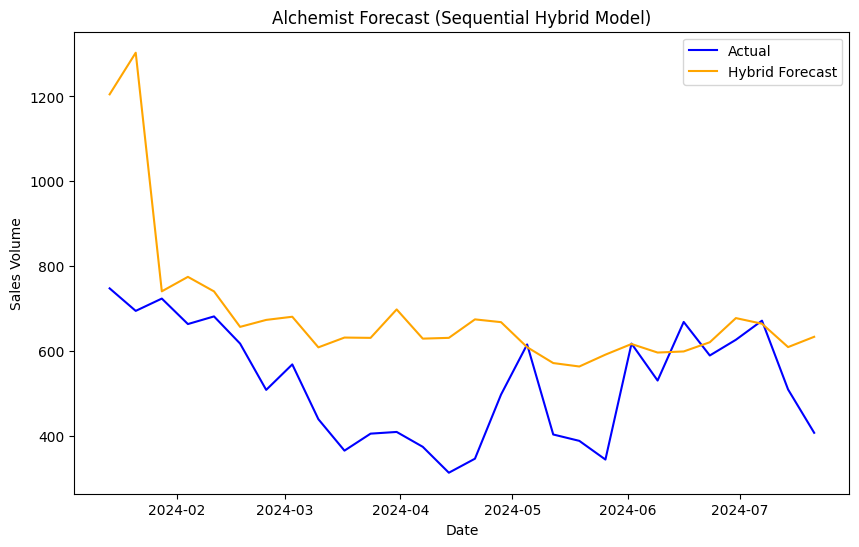

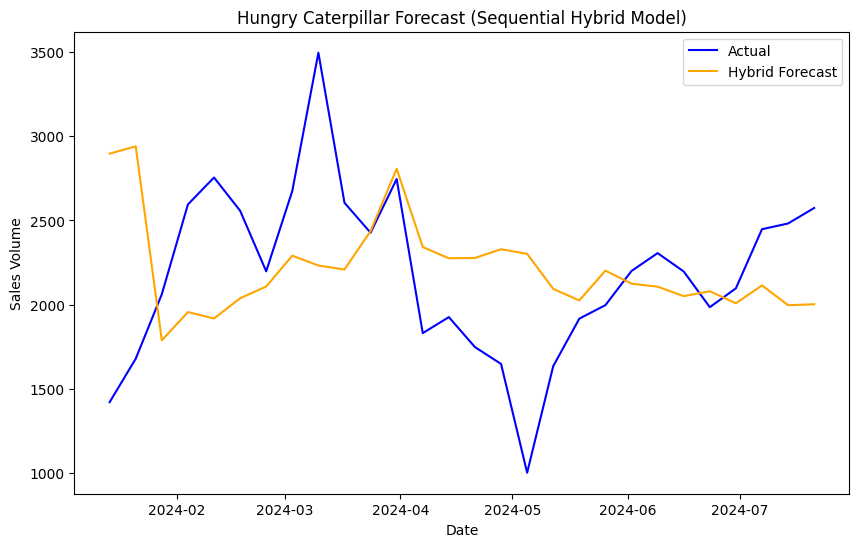

In [ ]:
# Adjusting SARIMA forecast horizon
sarima_forecast_alchemist = auto_arima_alchemist.predict(n_periods=32)
sarima_forecast_caterpillar = auto_arima_hungry_caterpillar.predict(n_periods=32)

# Predicting residuals using LSTM
alchemist_residual_forecast = alchemist_residuals_lstm.predict(alchemist_residuals_X[-32:])
caterpillar_residual_forecast = caterpillar_residuals_lstm.predict(caterpillar_residuals_X[-32:])

# Inverse scaling residuals
alchemist_residual_forecast = scaler_alchemist_residuals.inverse_transform(alchemist_residual_forecast)
caterpillar_residual_forecast = scaler_caterpillar_residuals.inverse_transform(caterpillar_residual_forecast)

# Combining SARIMA and LSTM residual forecasts
alchemist_hybrid_forecast = sarima_forecast_alchemist + alchemist_residual_forecast.flatten()
caterpillar_hybrid_forecast = sarima_forecast_caterpillar + caterpillar_residual_forecast.flatten()

# Slicing hybrid forecast to match actual test data length
alchemist_hybrid_forecast = alchemist_hybrid_forecast[:len(aligned_test_alchemist)]
caterpillar_hybrid_forecast = caterpillar_hybrid_forecast[:len(aligned_test_caterpillar)]

# Using aligned test data for evaluation
alchemist_hybrid_mae = mean_absolute_error(aligned_test_alchemist['Volume'], alchemist_hybrid_forecast)
alchemist_hybrid_mape = mean_absolute_percentage_error(aligned_test_alchemist['Volume'], alchemist_hybrid_forecast)
caterpillar_hybrid_mae = mean_absolute_error(aligned_test_caterpillar['Volume'], caterpillar_hybrid_forecast)
caterpillar_hybrid_mape = mean_absolute_percentage_error(aligned_test_caterpillar['Volume'], caterpillar_hybrid_forecast)

print(f"The Alchemist (Sequential Hybrid Model) - MAE: {alchemist_hybrid_mae}, MAPE: {alchemist_hybrid_mape}")
print(f"The Very Hungry Caterpillar (Sequential Hybrid Model) - MAE: {caterpillar_hybrid_mae}, MAPE: {caterpillar_hybrid_mape}")

# Plotting hybrid forecasts for The Alchemist
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_alchemist.index, aligned_test_alchemist['Volume'], label="Actual", color="blue")
plt.plot(aligned_test_alchemist.index, alchemist_hybrid_forecast, label="Hybrid Forecast", color="orange")
plt.title("Alchemist Forecast (Sequential Hybrid Model)")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.legend()
plt.show()

# Plotting hybrid forecasts for The Very Hungry Caterpillar
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_caterpillar.index, aligned_test_caterpillar['Volume'], label="Actual", color="blue")
plt.plot(aligned_test_caterpillar.index, caterpillar_hybrid_forecast, label="Hybrid Forecast", color="orange")
plt.title("Hungry Caterpillar Forecast (Sequential Hybrid Model)")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.legend()
plt.show()




- *The Alchemist*: MAE ~169, MAPE ~37%. The sequential combination of SARIMA + LSTM
  residuals overshoots the error of the standalone LSTM.
- *The Very Hungry Caterpillar*: MAE ~477, MAPE ~25%. This also underperforms the
  single LSTM approach.

Hence, while sequential hybridisation can be conceptually attractive, it did not
meaningfully boost forecasting accuracy here.

### Parallel Hybrid (Weighted SARIMA & LSTM)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Best Weight (The Alchemist): 0.7000000000000001, MAE: 111.38362455931886
Best Weight (The Very Hungry Caterpillar): 1.0, MAE: 482.81149853102886
The Alchemist (Parallel Hybrid Model) - MAPE: 0.20273702758041168
The Very Hungry Caterpillar (Parallel Hybrid Model) - MAPE: 0.25414303869330973


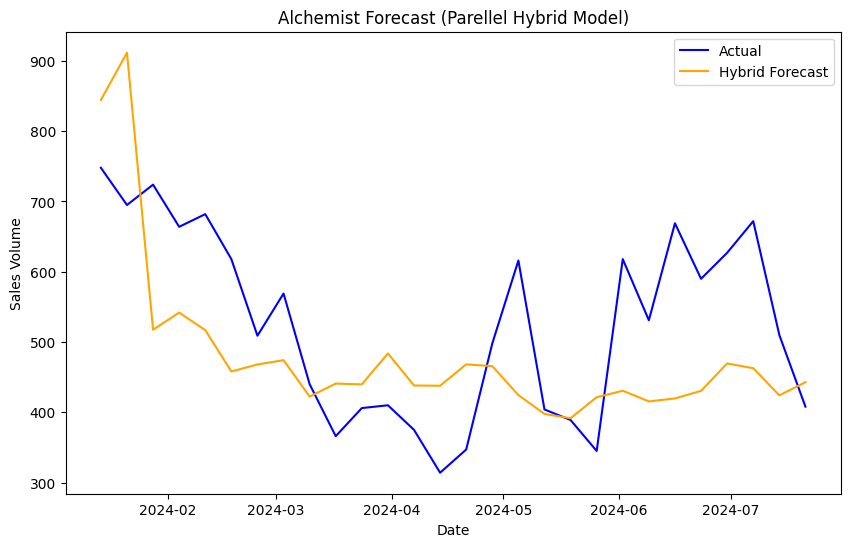

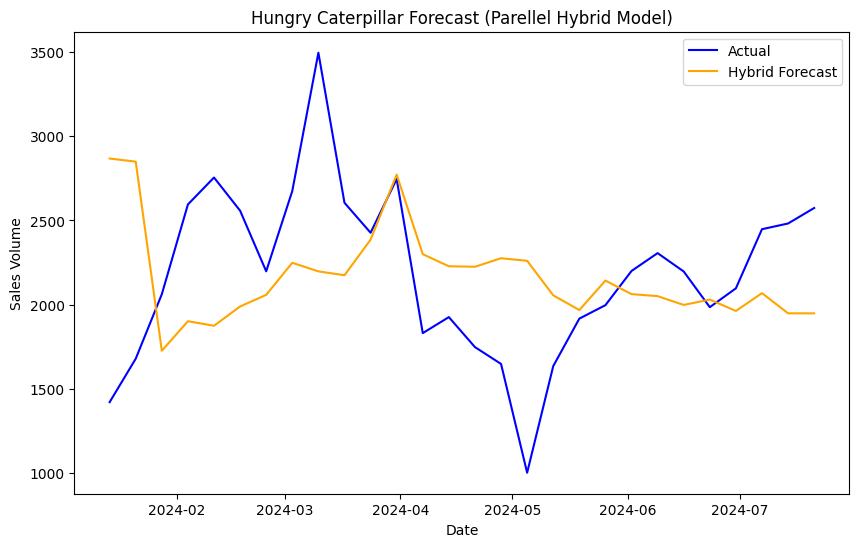

In [ ]:
# Defining a function to calculate weighted hybrid forecasts
def weighted_hybrid_forecast(sarima_forecast, lstm_forecast, weight_sarima):

    weight_lstm = 1 - weight_sarima
    return (weight_sarima * sarima_forecast) + (weight_lstm * lstm_forecast)

# Generating SARIMA forecasts for the final 32 weeks
sarima_forecast_alchemist = auto_arima_alchemist.predict(n_periods=32)
sarima_forecast_caterpillar = auto_arima_hungry_caterpillar.predict(n_periods=32)

# Generating LSTM forecasts for the final 32 weeks
alchemist_lstm_forecast = alchemist_residuals_lstm.predict(alchemist_residuals_X[-32:])
caterpillar_lstm_forecast = caterpillar_residuals_lstm.predict(caterpillar_residuals_X[-32:])

# Inverse scaling LSTM forecasts
alchemist_lstm_forecast = scaler_alchemist_residuals.inverse_transform(alchemist_lstm_forecast)
caterpillar_lstm_forecast = scaler_caterpillar_residuals.inverse_transform(caterpillar_lstm_forecast)

# Aligning forecasts with test data
sarima_forecast_alchemist = sarima_forecast_alchemist[:len(aligned_test_alchemist)]
alchemist_lstm_forecast = alchemist_lstm_forecast.flatten()[:len(aligned_test_alchemist)]

sarima_forecast_caterpillar = sarima_forecast_caterpillar[:len(aligned_test_caterpillar)]
caterpillar_lstm_forecast = caterpillar_lstm_forecast.flatten()[:len(aligned_test_caterpillar)]

# Finding the best weight by evaluating multiple weight combinations
best_weight_alchemist = None
best_mae_alchemist = float("inf")
best_weight_caterpillar = None
best_mae_caterpillar = float("inf")

weights = np.linspace(0, 1, 11)

for weight in weights:
    # Combining forecasts using the weight
    hybrid_forecast_alchemist = weighted_hybrid_forecast(
        sarima_forecast_alchemist, alchemist_lstm_forecast, weight
    )
    hybrid_forecast_caterpillar = weighted_hybrid_forecast(
        sarima_forecast_caterpillar, caterpillar_lstm_forecast, weight
    )

    # Calculating MAE for each weight
    mae_alchemist = mean_absolute_error(aligned_test_alchemist['Volume'], hybrid_forecast_alchemist)
    mae_caterpillar = mean_absolute_error(aligned_test_caterpillar['Volume'], hybrid_forecast_caterpillar)

    # Updating best weight if MAE improves
    if mae_alchemist < best_mae_alchemist:
        best_mae_alchemist = mae_alchemist
        best_weight_alchemist = weight

    if mae_caterpillar < best_mae_caterpillar:
        best_mae_caterpillar = mae_caterpillar
        best_weight_caterpillar = weight

# Printing best weights and corresponding MAEs
print(f"Best Weight (The Alchemist): {best_weight_alchemist}, MAE: {best_mae_alchemist}")
print(f"Best Weight (The Very Hungry Caterpillar): {best_weight_caterpillar}, MAE: {best_mae_caterpillar}")

# Combining forecasts using the best weights
final_hybrid_forecast_alchemist = weighted_hybrid_forecast(
    sarima_forecast_alchemist, alchemist_lstm_forecast, best_weight_alchemist
)
final_hybrid_forecast_caterpillar = weighted_hybrid_forecast(
    sarima_forecast_caterpillar, caterpillar_lstm_forecast, best_weight_caterpillar
)

# Evaluating final hybrid forecasts
alchemist_hybrid_mape = mean_absolute_percentage_error(aligned_test_alchemist['Volume'], final_hybrid_forecast_alchemist)
caterpillar_hybrid_mape = mean_absolute_percentage_error(aligned_test_caterpillar['Volume'], final_hybrid_forecast_caterpillar)

print(f"The Alchemist (Parallel Hybrid Model) - MAPE: {alchemist_hybrid_mape}")
print(f"The Very Hungry Caterpillar (Parallel Hybrid Model) - MAPE: {caterpillar_hybrid_mape}")

# Plotting final hybrid forecasts for The Alchemist
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_alchemist.index, aligned_test_alchemist['Volume'], label="Actual", color="blue")
plt.plot(aligned_test_alchemist.index, final_hybrid_forecast_alchemist, label="Hybrid Forecast", color="orange")
plt.title("Alchemist Forecast (Parellel Hybrid Model)")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.legend()
plt.show()

# Plotting final hybrid forecasts for The Very Hungry Caterpillar
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_caterpillar.index, aligned_test_caterpillar['Volume'], label="Actual", color="blue")
plt.plot(aligned_test_caterpillar.index, final_hybrid_forecast_caterpillar, label="Hybrid Forecast", color="orange")
plt.title("Hungry Caterpillar Forecast (Parellel Hybrid Model)")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.legend()
plt.show()


- *The Alchemist*: Best weight ~0.7 for SARIMA yields an MAE of about 111,
  outperforming the sequential hybrid. Yet, this still lags behind the pure LSTM’s
  strongest performance.
- *The Very Hungry Caterpillar*: A best weight of 1.0 implies that simply using SARIMA
  (no LSTM contribution) minimises MAE. This suggests the LSTM residual added minimal
  value in parallel for this title.



## Monthly Aggregation & Forecasting


### Training SARIMA & XGBoost Models




In [ ]:
# Combining training and test data
combined_alchemist = pd.concat([train_alchemist, test_alchemist]).sort_index()
combined_caterpillar = pd.concat([train_hungry_caterpillar, test_hungry_caterpillar]).sort_index()

# Aggregating into monthly data using the existing index
monthly_alchemist = combined_alchemist.resample('M').sum()
monthly_caterpillar = combined_caterpillar.resample('M').sum()

In [ ]:
# Paths to save XGBoost models
xgb_alchemist_monthly_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/xgb_alchemist_monthly.pkl"
xgb_caterpillar_monthly_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/xgb_caterpillar_monthly.pkl"

# Function to prepare supervised features for monthly data
def create_supervised_features_monthly(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df_supervised = pd.concat(columns, axis=1)
    df_supervised.columns = ['Lag_' + str(i) for i in range(1, lag + 1)] + ['Target']
    df_supervised.dropna(inplace=True)
    return df_supervised

# Preparing data for XGBoost
lag_features = 4
alchemist_monthly_supervised = create_supervised_features_monthly(monthly_alchemist['Volume'], lag=lag_features)
caterpillar_monthly_supervised = create_supervised_features_monthly(monthly_caterpillar['Volume'], lag=lag_features)

alchemist_X = alchemist_monthly_supervised.iloc[:, :-1]
alchemist_y = alchemist_monthly_supervised.iloc[:, -1]
caterpillar_X = caterpillar_monthly_supervised.iloc[:, :-1]
caterpillar_y = caterpillar_monthly_supervised.iloc[:, -1]

# Training or loading XGBoost models
from xgboost import XGBRegressor

if not os.path.exists(xgb_alchemist_monthly_path):
    print("Training XGBoost model for The Alchemist (Monthly)...")
    xgb_alchemist_monthly = XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    xgb_alchemist_monthly.fit(alchemist_X, alchemist_y)
    with open(xgb_alchemist_monthly_path, "wb") as f:
        pickle.dump(xgb_alchemist_monthly, f)
else:
    print("Loading XGBoost model for The Alchemist (Monthly)...")
    with open(xgb_alchemist_monthly_path, "rb") as f:
        xgb_alchemist_monthly = pickle.load(f)

if not os.path.exists(xgb_caterpillar_monthly_path):
    print("Training XGBoost model for The Very Hungry Caterpillar (Monthly)...")
    xgb_caterpillar_monthly = XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    xgb_caterpillar_monthly.fit(caterpillar_X, caterpillar_y)
    with open(xgb_caterpillar_monthly_path, "wb") as f:
        pickle.dump(xgb_caterpillar_monthly, f)
else:
    print("Loading XGBoost model for The Very Hungry Caterpillar (Monthly)...")
    with open(xgb_caterpillar_monthly_path, "rb") as f:
        xgb_caterpillar_monthly = pickle.load(f)


Loading XGBoost model for The Alchemist (Monthly)...
Loading XGBoost model for The Very Hungry Caterpillar (Monthly)...


Some publishers need less granular, longer-horizon forecasts for stock planning
and budget cycles. Monthly data can reveal high-level trends and seasonal shifts
without week-to-week noise, though at the expense of detail on short-term spikes.

In [ ]:
# Paths to save SARIMA models
sarima_alchemist_monthly_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/sarima_alchemist_monthly.pkl"
sarima_caterpillar_monthly_path = "/content/drive/My Drive/CAM DS 302 Week 9&10 data sets/sarima_caterpillar_monthly.pkl"

if not os.path.exists(sarima_alchemist_monthly_path):
    print("Training SARIMA model for The Alchemist (Monthly)...")
    sarima_alchemist_monthly = auto_arima(monthly_alchemist['Volume'], seasonal=True, m=12, trace=True)
    with open(sarima_alchemist_monthly_path, "wb") as f:
        pickle.dump(sarima_alchemist_monthly, f)
else:
    print("Loading SARIMA model for The Alchemist (Monthly)...")
    with open(sarima_alchemist_monthly_path, "rb") as f:
        sarima_alchemist_monthly = pickle.load(f)

if not os.path.exists(sarima_caterpillar_monthly_path):
    print("Training SARIMA model for The Very Hungry Caterpillar (Monthly)...")
    sarima_caterpillar_monthly = auto_arima(monthly_caterpillar['Volume'], seasonal=True, m=12, trace=True)
    with open(sarima_caterpillar_monthly_path, "wb") as f:
        pickle.dump(sarima_caterpillar_monthly, f)
else:
    print("Loading SARIMA model for The Very Hungry Caterpillar (Monthly)...")
    with open(sarima_caterpillar_monthly_path, "rb") as f:
        sarima_caterpillar_monthly = pickle.load(f)


Loading SARIMA model for The Alchemist (Monthly)...
Loading SARIMA model for The Very Hungry Caterpillar (Monthly)...


### Forecasting Monthly Sales



In [ ]:
# Forecast horizon: 8 months
forecast_horizon = 8

# XGBoost forecasts
alchemist_xgb_forecast = xgb_alchemist_monthly.predict(alchemist_X[-forecast_horizon:])
caterpillar_xgb_forecast = xgb_caterpillar_monthly.predict(caterpillar_X[-forecast_horizon:])

# SARIMA forecasts
sarima_alchemist_forecast = sarima_alchemist_monthly.predict(n_periods=forecast_horizon)
sarima_caterpillar_forecast = sarima_caterpillar_monthly.predict(n_periods=forecast_horizon)

# Evaluating MAE and MAPE
alchemist_actual = monthly_alchemist['Volume'][-forecast_horizon:]
caterpillar_actual = monthly_caterpillar['Volume'][-forecast_horizon:]

alchemist_xgb_mae = mean_absolute_error(alchemist_actual, alchemist_xgb_forecast)
alchemist_xgb_mape = mean_absolute_percentage_error(alchemist_actual, alchemist_xgb_forecast)

alchemist_sarima_mae = mean_absolute_error(alchemist_actual, sarima_alchemist_forecast)
alchemist_sarima_mape = mean_absolute_percentage_error(alchemist_actual, sarima_alchemist_forecast)

caterpillar_xgb_mae = mean_absolute_error(caterpillar_actual, caterpillar_xgb_forecast)
caterpillar_xgb_mape = mean_absolute_percentage_error(caterpillar_actual, caterpillar_xgb_forecast)

caterpillar_sarima_mae = mean_absolute_error(caterpillar_actual, sarima_caterpillar_forecast)
caterpillar_sarima_mape = mean_absolute_percentage_error(caterpillar_actual, sarima_caterpillar_forecast)

print("The Alchemist (XGBoost) MAE:", alchemist_xgb_mae, ", MAPE:", alchemist_xgb_mape)
print("The Alchemist (SARIMA) MAE:", alchemist_sarima_mae, ", MAPE:", alchemist_sarima_mape)

print("The Very Hungry Caterpillar (XGBoost) MAE:", caterpillar_xgb_mae, ", MAPE:", caterpillar_xgb_mape)
print("The Very Hungry Caterpillar (SARIMA) MAE:", caterpillar_sarima_mae, ", MAPE:", caterpillar_sarima_mape)


The Alchemist (XGBoost) MAE: 200.0734405517578 , MAPE: 0.07908906042575836
The Alchemist (SARIMA) MAE: 1326.628071333796 , MAPE: 0.4877942195397996
The Very Hungry Caterpillar (XGBoost) MAE: 703.7968139648438 , MAPE: 0.07225149124860764
The Very Hungry Caterpillar (SARIMA) MAE: 2863.039535250134 , MAPE: 0.3193442664049831


- **XGBoost** consistently outperforms SARIMA for both books, with notably lower
  MAE and MAPE.
- *The Alchemist*: SARIMA’s errors spike due to the model’s weaker handling of
  shifts in monthly data. XGBoost adapts better to limited monthly observations.
- *The Very Hungry Caterpillar*: XGBoost again demonstrates lower absolute and
  relative errors, though the larger overall volume means occasional high sales
  spikes remain challenging to predict perfectly.

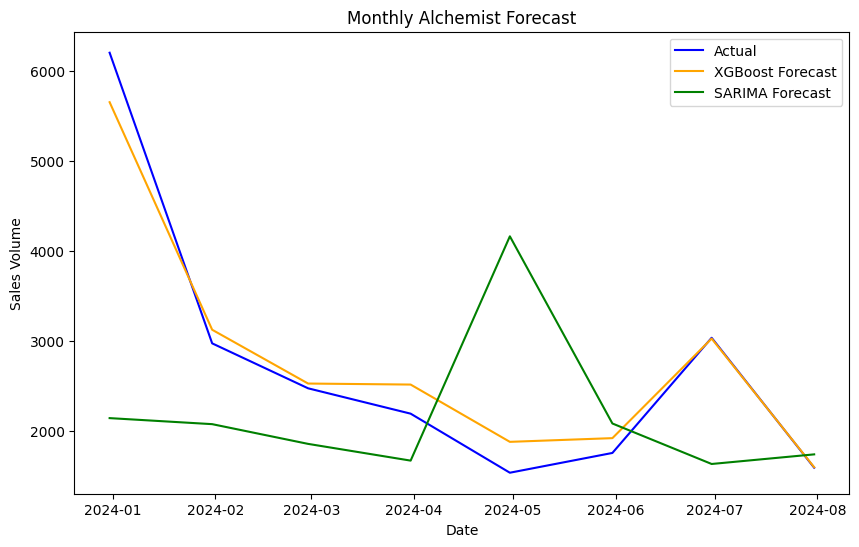

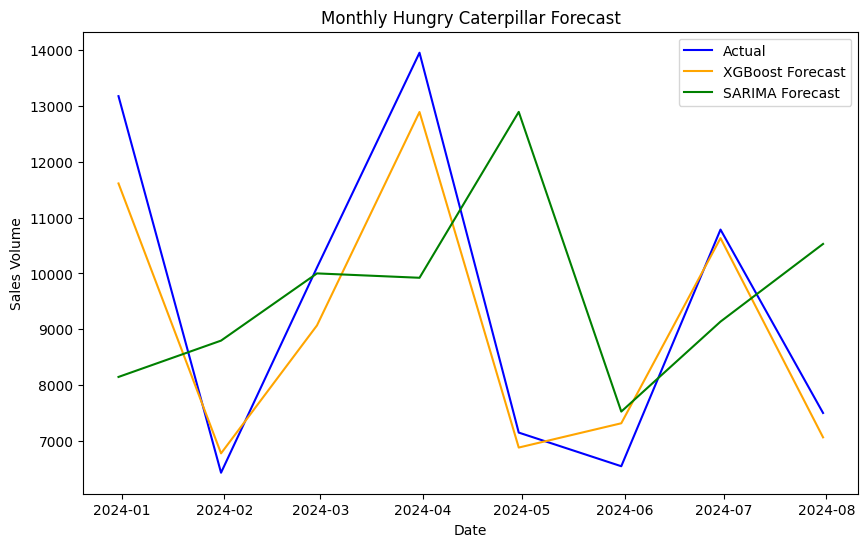

In [ ]:
# Plot forecasts for The Alchemist
plt.figure(figsize=(10, 6))
plt.plot(monthly_alchemist.index[-forecast_horizon:], alchemist_actual, label="Actual", color="blue")
plt.plot(monthly_alchemist.index[-forecast_horizon:], alchemist_xgb_forecast, label="XGBoost Forecast", color="orange")
plt.plot(monthly_alchemist.index[-forecast_horizon:], sarima_alchemist_forecast, label="SARIMA Forecast", color="green")
plt.title("Monthly Alchemist Forecast")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.legend()
plt.show()

# Plot forecasts for The Very Hungry Caterpillar
plt.figure(figsize=(10, 6))
plt.plot(monthly_caterpillar.index[-forecast_horizon:], caterpillar_actual, label="Actual", color="blue")
plt.plot(monthly_caterpillar.index[-forecast_horizon:], caterpillar_xgb_forecast, label="XGBoost Forecast", color="orange")
plt.plot(monthly_caterpillar.index[-forecast_horizon:], sarima_caterpillar_forecast, label="SARIMA Forecast", color="green")
plt.title("Monthly Hungry Caterpillar Forecast")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.legend()
plt.show()


- **Weekly**: Yields finer-grained insights, typically lower absolute errors (MAE)
  but higher relative errors (MAPE) when sales jump unpredictably.
- **Monthly**: Smooths irregularities, often improving MAPE for strategic planning,
  but may obscure short-lived sales surges that matter for immediate stocking needs.
- **Model Choice**: For near-term reorders, a weekly LSTM or XGBoost may be best.
  For longer-term budgeting, monthly XGBoost forecasts present a clearer trend view.


## Conclusion

XGBoost delivered the most consistent performance across weekly and monthly forecasts, outperforming SARIMA and hybrid models. The SARIMA-LSTM hybrid showed some improvements for *The Alchemist* but added little value for *The Very Hungry Caterpillar*. Weekly forecasts capture short-term fluctuations but introduce more noise, whereas monthly forecasts provide a clearer trend for long-term planning. For operational decision-making, XGBoost or LSTM weekly models may be preferred, while monthly XGBoost forecasts offer a stable view for strategic planning. Future work could explore external factors such as promotions or seasonality to further improve forecast accuracy.
